# Univariate and Decoding Analyses wrapper. 
This notebook aggregates the results from individual sessions (or computes them- if not previoulsy run). It further has the code to analyse the data at the group level including plots. 

These analyses include various univariate analyses and decoding analyses, all focused on differeiating Left vs Right coding as a function of the cue or the decision.

author: ag
last updated: 9/24/19

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import sys, os, time, json
from pathlib import Path
import pickle as pkl

sys.path.append('../PreProcessing/')
sys.path.append('../Lib/')
sys.path.append('../Analyses/')

import analyses_table as AT
import stem_branch_analyses as SBA
from importlib import reload  # Python 3.4+ only.

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
oakPaths = AT.getOakPaths()

sns.set(style="whitegrid",font_scale=1,rc={
    'axes.spines.bottom': False,
'axes.spines.left': False,
'axes.spines.right': False,
'axes.spines.top': False,
'axes.edgecolor':'0.5'})

sns.set_context("poster")
plotSP = Path('/mnt/c/Users/alexg8/Documents/SfN2019/Plots/')

load data 

In [23]:
fn = oakPaths['Analyses'] / 'SBA_All_Uni.csv'
All_UniRes = pd.read_csv(fn,index_col=0)

fn = oakPaths['Analyses'] / 'SBA_All_Dec.csv'
All_DecRes  = pd.read_csv(fn,index_col=0)

fn = oakPaths['Analyses'] / 'SBA_All_PopDec.csv'
All_PopDecRes = pd.read_csv(fn,index_col=0)

fn = oakPaths['Analyses'] / 'SBA_All_PopSumDec.csv'
All_PopSumDecRes = pd.read_csv(fn,index_col=0)

# behavioral
All_BehDat = pd.read_csv(oakPaths['Analyses'] / 'TaskBehavior.csv',index_col=0)
All_BehDat = All_BehDat.set_index('se')

or run code below to create data structs.

In [6]:
AT = reload(AT)
SBA = reload(SBA)

#task = 'T3g'

tasks = ['T3h','T3g','T3j','T3i']

animals = ['Li','Ne','Cl']
overwrite= False
doPlots = False

All_UniRes = pd.DataFrame()
All_DecRes = pd.DataFrame()
All_PopDecRes = pd.DataFrame()
for animal in animals:
    
    fn = oakPaths['Root'] / (animal+'_SessionPaths.pkl')
    with fn.open(mode="rb") as f:
        sePaths = pkl.load(f)

    CT_Path =  oakPaths['Clustered'] / animal / (animal+'_ClusteringSummary.json')
    CueDesDat_Fn = oakPaths['Analyses'] / animal / ('{}_CueDesSegRes.csv').format(animal)
    CueDesDecDat_Fn = oakPaths['Analyses'] / animal / ('{}_CueDesSegDecRes.csv').format(animal)
    CueDesPopDecDat_Fn = oakPaths['Analyses'] / animal / ('{}_CueDesSegDecPopRes.csv').format(animal)
    with CT_Path.open() as f:
        CT = json.load(f)
    
    SessionList = []
    cnt=0
    uniRes = pd.DataFrame()
    decRes = pd.DataFrame()
    popDecRes = pd.DataFrame()
    for se,v in CT['Sessions'].items():
        if v:
            temp = se.split('_')
            task = temp[1]
            if task in tasks:
                try:
                    print('Analysing Session {}'.format(se))
                    SessionList.append(se)
                    x, _, y, z = SBA.main(sePaths[se],overwrite=overwrite,doPlots=doPlots)
                    for ii in ['se','task']:
                        x[ii] = eval(ii)
                        y[ii] = eval(ii)
                        z[ii] = eval(ii)
                        
                    if isinstance(x,pd.DataFrame):
                        uniRes = pd.concat((uniRes,x))
                        decRes = pd.concat((decRes,y))
                        popDecRes = pd.concat((popDecRes,z))
                except KeyboardInterrupt:
                    break
                except:
                    print("Error processing session: {}".format(se))
                    print ("Error", sys.exc_info()[0],sys.exc_info()[1],sys.exc_info()[2].tb_lineno)
                #break
    #break

    uniRes.to_csv(CueDesDat_Fn)
    decRes.to_csv(CueDesDecDat_Fn)
    popDecRes.to_csv(CueDesPopDecDat_Fn)
    
    uniRes['an'] = animal
    decRes['an'] = animal
    popDecRes['an'] = animal
    
    All_UniRes = pd.concat((All_UniRes,uniRes))
    All_DecRes = pd.concat((All_DecRes,decRes))
    All_PopDecRes = pd.concat((All_PopDecRes,popDecRes))

   


Analysing Session Li_T3g_052818
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_052918
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_053018
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_053118
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_060118
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_060418
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_061318
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_061518
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_061818
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_062018
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_062518
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_062618
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_062718
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_062818
Loading Beh Tracking Data
Complete.
Analysing Session Li_T3g_070218
Loading Beh Trac

In [103]:
All_BehDat = pd.read_csv(oakPaths['Analyses'] / 'TaskBehavior.csv',index_col=0)
All_BehDat = All_BehDat.set_index('se')
All_BehDat

,an,task,nTrials,nDiscard,nCo,nInCo,nLD,nRD,nLC,nRC,nST,pCo,pCoST
se,,,,,,,,,,,,,
Li_T3g_052818,Li,T3g,38,22,27,11,16,22,19,19,21,0.710526,0.809524
Li_T3g_052918,Li,T3g,154,24,133,21,74,80,81,73,51,0.863636,0.862745
Li_T3g_053018,Li,T3g,121,24,98,23,36,85,55,66,49,0.809917,0.816327
Li_T3g_053118,Li,T3g,140,20,111,29,54,86,71,69,69,0.792857,0.840580
Li_T3g_060118,Li,T3g,159,16,134,25,70,89,79,80,63,0.842767,0.857143
Li_T3g_060418,Li,T3g,130,14,108,22,65,65,73,57,57,0.830769,0.842105
Li_T3g_061318,Li,T3g,122,32,91,31,60,62,67,55,63,0.745902,0.698413
Li_T3g_061518,Li,T3g,112,17,73,39,68,44,65,47,61,0.651786,0.540984
Li_T3g_061818,Li,T3g,134,21,109,25,60,74,61,73,66,0.813433,0.863636


Add behavioral session data to the neural data tables. 

In [104]:
 # behavioral
All_BehDat = pd.read_csv(oakPaths['Analyses'] / 'TaskBehavior.csv',index_col=0)
All_BehDat = All_BehDat.set_index('se')

def addBehToDF(dat,beh):
    X = dat.copy()
    try:
        X = X.reset_index()
    except:
        pass
    X['nTrials'] = np.nan
    X['pCo'] = np.nan
    X['pCoST'] = np.nan
    for se in beh.index:
        subset = X['se'] == se
        X.loc[subset,'nTrials'] = beh.loc[se,'nTrials']
        X.loc[subset,'pCo'] = beh.loc[se,'pCo']
        X.loc[subset,'pCoST'] = beh.loc[se,'pCoST']
    return X


def addUnitID(dat):
    unitCnt = 0
    dat['uID'] = np.nan
    for se in dat['se'].unique():
        subset = dat['se']==se
        nSeUnits = dat[subset]['unit'].max()+1
        for unit in np.arange(nSeUnits):
            sub2 = subset & (dat['unit']==unit)
            dat.loc[sub2,'uID'] = unitCnt
            unitCnt+=1
    return dat

def addSeUnits(dat):
    unitCnt = 0
    dat['uID'] = np.nan
    for se in dat['se'].unique():
        subset = dat['se']==se
        nSeUnits = dat[subset]['unit'].max()+1
        for unit in np.arange(nSeUnits):
            sub2 = subset & (dat['unit']==unit)
            dat.loc[sub2,'uID'] = unitCnt
            unitCnt+=1
    return dat


All_UniRes=addBehToDF(All_UniRes,All_BehDat)
All_DecRes=addBehToDF(All_DecRes,All_BehDat)
All_UniRes=addUnitID(All_UniRes)
All_DecRes=addUnitID(All_DecRes)

X = All_PopDecRes.groupby(['Loc','Test','Decoder','se','an']).mean()
X = X.reset_index()
X['Test'] = pd.Categorical(X['Test'],categories=['Model','Cue','Desc'],ordered=True)
X.sort_values('Test',inplace=True)
X['Loc'] = pd.Categorical(X['Loc'],categories=['h','a','center','be','int','cdfg','goal'],ordered=True)
X.sort_values('Loc',inplace=True)

All_PopSumDecRes = X
All_PopSumDecRes=addBehToDF(All_PopSumDecRes,All_BehDat)

In [11]:
All_UniRes

,index,unit,Seg,MzFR_L,Cond,MzFR_R,SzFR_L,SzFR_R,T,P,S,Sig,se,task,an,nTrials,pCo,pCoST,uID
0,0,0,A,-0.362835,Cue,-0.305447,0.103343,0.121370,-0.360011,0.720943,,False,None,None,Li,0,0.0,0.0,0
1,1,1,A,1.127824,Cue,1.080496,0.193053,0.177391,0.180521,0.857756,,False,None,None,Li,0,0.0,0.0,0
2,2,2,A,0.322366,Cue,0.316038,0.154969,0.143780,0.029933,0.976286,,False,None,None,Li,0,0.0,0.0,0
3,3,3,A,1.419006,Cue,0.937034,0.211783,0.241662,1.499934,0.142351,,False,None,None,Li,0,0.0,0.0,0
4,4,4,A,0.009443,Cue,0.280248,0.192287,0.196740,-0.984383,0.331497,,False,None,None,Li,0,0.0,0.0,0
5,5,5,A,-0.157478,Cue,0.177151,0.135957,0.118788,-1.853480,0.072023,,False,None,None,Li,0,0.0,0.0,0
6,6,6,A,0.623556,Cue,0.698902,0.130148,0.132713,-0.405344,0.687623,,False,None,None,Li,0,0.0,0.0,0
7,7,7,A,0.780802,Cue,0.431142,0.130452,0.160726,1.689147,0.099836,,False,None,None,Li,0,0.0,0.0,0
8,8,8,A,0.406044,Cue,0.441500,0.177320,0.165243,-0.146282,0.884515,,False,None,None,Li,0,0.0,0.0,0
9,9,9,A,0.568326,Cue,0.621466,0.212816,0.172526,-0.193969,0.847290,,False,None,None,Li,0,0.0,0.0,0


In [266]:
All_PopSumDecRes['nSeUnits'] = np.nan
All_PopSumDecRes['task'] = ''

for se in All_DecRes['se'].unique():
    nSeUnits = len(All_DecRes[All_DecRes['se']==se]['unit'].unique())
    task = se.split('_')[1]
    datSub = All_PopSumDecRes['se']==se
    All_PopSumDecRes.loc[datSub,'nSeUnits'] = nSeUnits
    All_PopSumDecRes.loc[datSub,'task'] = task

'T3i'

save data

In [363]:
fn = oakPaths['Analyses'] / 'SBA_All_Uni.csv'
All_UniRes.to_csv(fn)
fn = oakPaths['Analyses'] / 'SBA_All_Dec.csv'
All_DecRes.to_csv(fn)
fn = oakPaths['Analyses'] / 'SBA_All_PopDec.csv'
All_PopDecRes.to_csv(fn)
fn = oakPaths['Analyses'] / 'SBA_All_PopSumDec.csv'
All_PopSumDecRes.to_csv(fn)

### Auxiliary imports and function defs.

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib_venn import venn2,venn3

def getSig(pvals):
    
    n = len(pvals)
    s = ['']*n
    cnt=0
    for p in pvals:
        if p<0.001:
            s[cnt] = '***'
        elif p<0.01:
            s[cnt] = '**'
        elif p<0.05:
            s[cnt] ='*'
        elif p<0.1:
            s[cnt] ='~'
        else:
            s[cnt] =''
        cnt+=1
    return s

In [11]:
sns.set_context('poster')

## I. First Analyses. Cue Coding.

number of units showing A coding in segment Cue: 101 / 1081 = 0.093
number of units showing Stem coding in segment Cue: 129 / 1081 = 0.119
number of units showing Arm coding in segment Cue: 364 / 1081 = 0.337


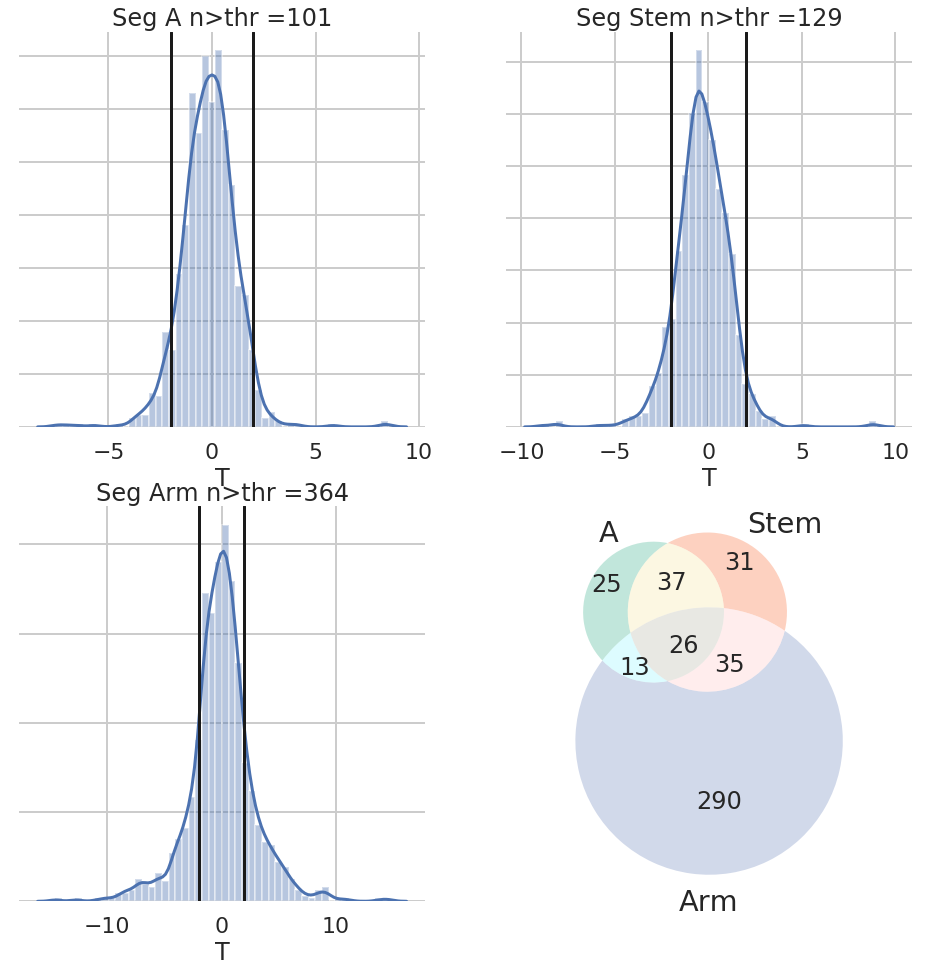

In [364]:
Segs =  ['A','Stem','Arm']
c = 'Cue'

UniCellSets = {}
UniCellSets[c] = {}
f,ax = plt.subplots(2,2,figsize=(16,16))
ax=ax.flatten()
cnt=0
for s in Segs:
    subset = (All_UniRes['Seg']==s) & (All_UniRes['Cond']==c) 

    ax[cnt]=sns.distplot(All_UniRes[subset]['T'],ax=ax[cnt])

    thr = 2
    ax[cnt].axvline(-thr,color='k')
    ax[cnt].axvline(thr,color='k')
    x=np.abs(All_UniRes[subset]['T'])>thr
    UniCellSets[c][s] = set(All_UniRes[subset]['uID'][x].values)
    ax[cnt].set_title('Seg ' + s +' n>thr ='+str(np.sum(x)))
    
    
    ax[cnt].set_yticklabels([])
    print( 'number of units showing {0} coding in segment {1}: {2} / {3} = {4:.3f}'.format(s,c,np.sum(x),len(x),np.mean(x)))
    cnt+=1
plt.sca(ax[3])

cols = ['#66c2a5','#fc8d62','#8da0cb']
_=venn3([UniCellSets[c]['A'],UniCellSets[c]['Stem'],UniCellSets[c]['Arm']],set_labels=Segs,set_colors=(cols[0],cols[1],cols[2]))
f.savefig(plotSP / 'SegTvalsDist_Cue.svg', bbox_inches='tight', pad_inches=0.2)


## II. Dec Analyses:

number of units showing A coding in segment Desc: 125 / 1081 = 0.116
number of units showing Stem coding in segment Desc: 158 / 1081 = 0.146
number of units showing Arm coding in segment Desc: 555 / 1081 = 0.513


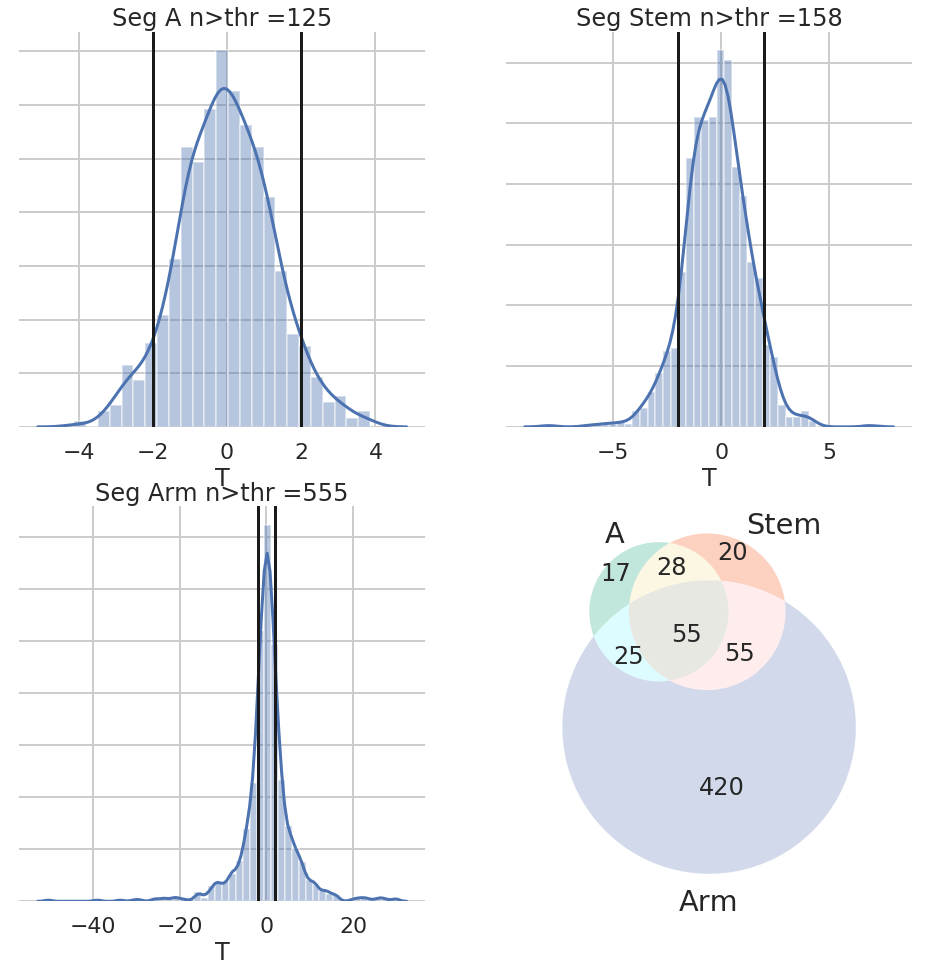

In [365]:
Segs =  ['A','Stem','Arm']
c = 'Desc'

UniCellSets[c] = {}
f,ax = plt.subplots(2,2,figsize=(16,16))
ax=ax.flatten()
cnt=0
for s in Segs:
    subset = (All_UniRes['Seg']==s) & (All_UniRes['Cond']==c) 

    ax[cnt]=sns.distplot(All_UniRes[subset]['T'],ax=ax[cnt])

    thr = 2
    ax[cnt].axvline(-thr,color='k')
    ax[cnt].axvline(thr,color='k')
    x=np.abs(All_UniRes[subset]['T'])>thr
    UniCellSets[c][s] = set(All_UniRes[subset]['uID'][x].values)
    ax[cnt].set_title('Seg ' + s +' n>thr ='+str(np.sum(x)))
    
    ax[cnt].set_yticklabels([])

    print( 'number of units showing {0} coding in segment {1}: {2} / {3} = {4:.3f}'.format(s,c,np.sum(x),len(x),np.mean(x)))
    cnt+=1
    
plt.sca(ax[3])
cols = ['#66c2a5','#fc8d62','#8da0cb']
_=venn3([UniCellSets[c]['A'],UniCellSets[c]['Stem'],UniCellSets[c]['Arm']],set_labels=Segs,set_colors=(cols[0],cols[1],cols[2]))
f.savefig(plotSP / 'SegTvalsDist_Dec.svg', bbox_inches='tight', pad_inches=0.2)


## III. Cue/Dec overlap.

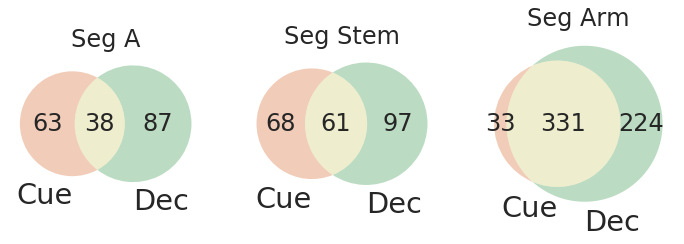

In [366]:
f,ax = plt.subplots(1,3,figsize=(12,4))
cols = sns.color_palette()[1:3]
ax=ax.flatten()
cnt=0
for s in Segs:
    plt.sca(ax[cnt])
    _ = venn2([UniCellSets['Cue'][s],UniCellSets['Desc'][s]],set_labels=['Cue','Dec'],set_colors=(cols[0],cols[1]))
    ax[cnt].set_title('Seg ' + s )
    cnt+=1
f.savefig(plotSP / 'SelCells_CueDec.svg', bbox_inches='tight', pad_inches=0.2)

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (1.0, 0.9294117647058824, 0.43529411764705883)]

number of units showing Co_Arm coding in segment Cue_Desc: 446 / 930 = 0.480
number of units showing L_Arm coding in segment Cue_Desc: 94 / 930 = 0.101
number of units showing R_Arm coding in segment Cue_Desc: 73 / 930 = 0.078


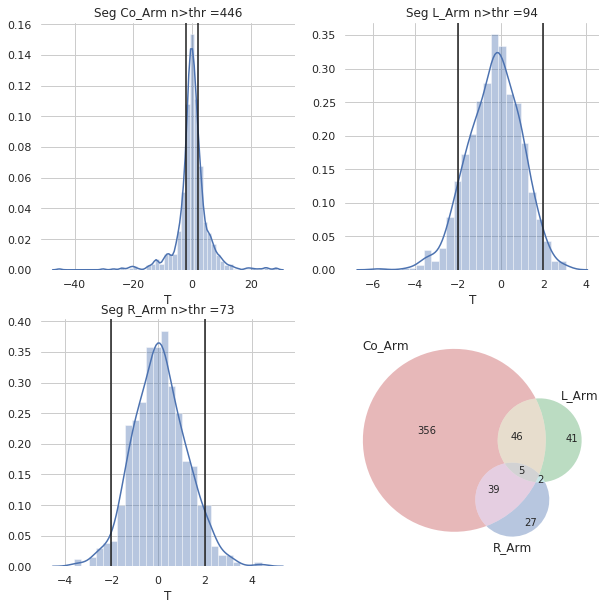

In [42]:
Segs =  ['Co_Arm','L_Arm','R_Arm']
c = 'Cue_Desc'

CellSets[c] = {}
f,ax = plt.subplots(2,2,figsize=(10,10))
ax=ax.flatten()
cnt=0
for s in Segs:
    subset = (All_UniRes['Seg']==s) & (All_UniRes['Cond']==c) 

    ax[cnt]=sns.distplot(All_UniRes[subset]['T'].dropna(),ax=ax[cnt])

    thr = 2
    ax[cnt].axvline(-thr,color='k')
    ax[cnt].axvline(thr,color='k')
    x=np.abs(All_UniRes[subset]['T'])>thr
    CellSets[c][s] = set(All_UniRes[subset]['uID'][x].values)
    ax[cnt].set_title('Seg ' + s +' n>thr ='+str(np.sum(x)))
    
    print( 'number of units showing {0} coding in segment {1}: {2} / {3} = {4:.3f}'.format(s,c,np.sum(x),len(x),np.mean(x)))
    cnt+=1
    
plt.sca(ax[3])
_=venn3([CellSets[c][Segs[0]],CellSets[c][Segs[1]],CellSets[c][Segs[2]]],set_labels=Segs)

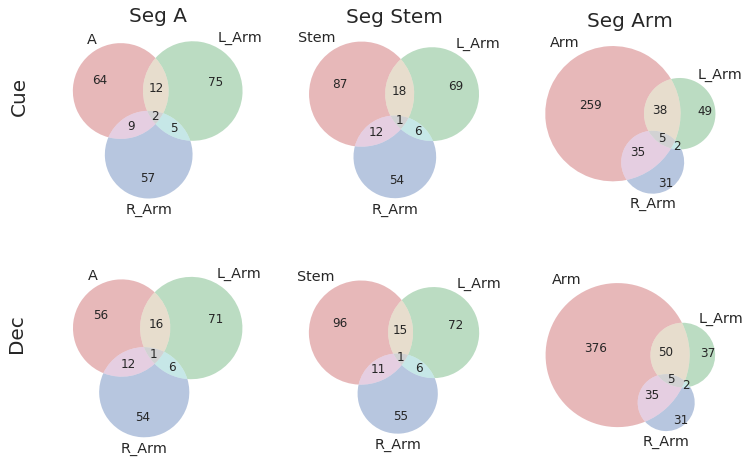

In [46]:
f,ax = plt.subplots(2,3,figsize=(12,8))

Segs = ['A','Stem','Arm']
Conds = ['Cue','Desc']
ii=0
for c in Conds:
    jj = 0
    for s in Segs:
        plt.sca(ax[ii,jj])
        _=venn3([CellSets[c][s],CellSets['Cue_Desc']['L_Arm'],CellSets['Cue_Desc']['R_Arm'] ],set_labels=[s,'L_Arm','R_Arm'])
        if ii==0:
            ax[ii,jj].set_title('Seg ' + s,fontsize=20)
        jj+=1
    ii+=1
_=ax[0,0].text(-1,0.1,'Cue',fontsize=20,rotation='vertical',verticalalignment='center',horizontalalignment='center')
_=ax[1,0].text(-1,0.1,'Dec',fontsize=20,rotation='vertical',verticalalignment='center',horizontalalignment='center')


## IV. Behavior to activity analyses. 
1) is the extent to which the cue is represented at the different parts of the maze indicative of performance?

In [375]:
import statsmodels.formula.api as smf

tol = 0.001
f = lambda x: np.log( (x+tol) /(1- (x+tol)))
All_UniRes['aT'] = np.abs(All_UniRes['T'])
All_UniRes['T2'] = (All_UniRes['T'])**2
All_UniRes['L_pCo'] =  f(All_UniRes['pCo'])

mdf = {}
for c in ['Cue','Desc','Cue_Desc']:
    subset = (All_UniRes['Cond']==c)  & (All_UniRes['task']!='T3j') #& (All_UniRes['task']=='T3g')

    dat =[]
    dat = All_UniRes[subset]
    dat = dat[~dat['T'].isnull()]

    md =smf.mixedlm('L_pCo ~ Seg:aT + task',data=dat,groups=dat['an'])
    mdf[c] = md.fit()
    print(mdf[c].summary())
    print(mdf[c].wald_test_terms())
    print("R2 = {0:.3f}".format((np.corrcoef(mdf[c].fittedvalues,dat['L_pCo'])**2)[0,1]))

    print()

subset = ((All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc')) & (All_UniRes['task']!='T3j')
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = All_UniRes[subset]
dat = dat[~dat['T'].isnull()]
#md =smf.mixedlm('L_pCo ~ Seg:aT * Cond+task',data=dat,groups=dat['an'])
md =smf.mixedlm('L_pCo ~ Seg*aT * Cond + task',data=dat,groups=dat['an'])

#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())
print("R2 = {0:.3f}".format((np.corrcoef(mdf['x'].fittedvalues,dat['L_pCo'])**2)[0,1]))

print()

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: L_pCo     
No. Observations: 3234    Method:             REML      
No. Groups:       3       Scale:              0.1800    
Min. group size:  576     Likelihood:         -1836.9413
Max. group size:  1491    Converged:          Yes       
Mean group size:  1078.0                                
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     1.468    0.103  14.274 0.000  1.267  1.670
task[T.T3i]  -1.179    0.022 -53.064 0.000 -1.222 -1.135
Seg[A]:aT     0.060    0.012   5.191 0.000  0.037  0.083
Seg[Arm]:aT   0.037    0.005   7.124 0.000  0.027  0.048
Seg[Stem]:aT  0.056    0.011   5.320 0.000  0.036  0.077
Group Var     0.031    0.074                            

                  chi2                  P>chi2  df constraint
Intercept   203.735179  3.197193110

In [373]:
sub1 = (All_UniRes['task']=='T3g') & (All_UniRes['Cond']=='Cue') & (All_UniRes['Seg']=='A') 
sub2 = (All_UniRes['task']=='T3i') & (All_UniRes['Cond']=='Cue') & (All_UniRes['Seg']=='A') 
stats.mannwhitneyu(All_UniRes[sub1]['aT'],All_UniRes[sub2]['aT'])

MannwhitneyuResult(statistic=70664.0, pvalue=0.3252164873354194)

In [116]:
subset = ((All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') ) & (All_UniRes['Seg']=='A') & (All_UniRes['task']!='T3j')
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = All_UniRes.loc[subset]
dat = dat[~dat['T'].isnull()]
md =smf.mixedlm('L_pCo~ aT:Cond*task',data=dat,groups=dat['an'])
print(md.fit().summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     L_pCo     
No. Observations:      2156        Method:                 REML      
No. Groups:            3           Scale:                  0.1832    
Min. group size:       384         Likelihood:             -1250.0606
Max. group size:       994         Converged:              Yes       
Mean group size:       718.7                                         
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  1.521    0.104  14.693 0.000  1.318  1.724
task[T.T3i]               -1.223    0.039 -30.992 0.000 -1.301 -1.146
aT:Cond[Cue]               0.023    0.016   1.441 0.150 -0.008  0.054
aT:Cond[Desc]              0.005    0.016   0.286 0.775 -0.027  0.036
aT:Cond[Cue]:task[T.T3i]   0.045    

In [83]:
#subset = ((All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') ) & (All_UniRes['task']!='T3j') & (All_UniRes['Seg']=='A')
subset = ((All_UniRes['Cond']=='Cue') ) & (All_UniRes['task']!='T3j') 
dat =[]
dat = All_UniRes.loc[subset]
dat = dat[~dat['T'].isnull()]
md =smf.mixedlm('aT ~ Seg*task',data=dat,groups=dat['an'])
print(md.fit().summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    aT        
No. Observations:     3234       Method:                REML      
No. Groups:           3          Scale:                 1.9393    
Min. group size:      576        Likelihood:            -5669.5990
Max. group size:      1491       Converged:             Yes       
Mean group size:      1078.0                                      
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.968    0.098  9.923 0.000  0.777  1.159
Seg[T.Arm]               1.142    0.065 17.598 0.000  1.015  1.269
Seg[T.Stem]              0.106    0.065  1.634 0.102 -0.021  0.233
task[T.T3i]              0.273    0.122  2.236 0.025  0.034  0.513
Seg[T.Arm]:task[T.T3i]  -0.823    0.170 -4.841 0.000 -1.157 -0.490
Seg[T.Stem

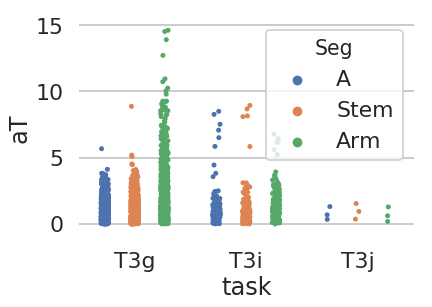

In [126]:
subset = (All_UniRes['Cond']=='Cue') #| (All_UniRes['Cond']=='Desc')
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = All_UniRes[subset]
sns.stripplot(x='task',y='aT',hue='Seg',data=dat,dodge=True)

In [127]:
subset1 = (dat['task']=='T3g') & (dat['Seg']=='A')
subset2 = (dat['task']=='T3i') & (dat['Seg']=='A')

dat[subset1]['aT'].median(),dat[subset2]['aT'].median(),

(0.8008916264839171, 0.7848839084388838)

In [135]:
mdf['x'].pvalues[6:9]

Seg[A]:aT:Cond[T.Desc]       8.833229e-04
Seg[Arm]:aT:Cond[T.Desc]     2.648136e-09
Seg[Stem]:aT:Cond[T.Desc]    4.032920e-03
dtype: float64

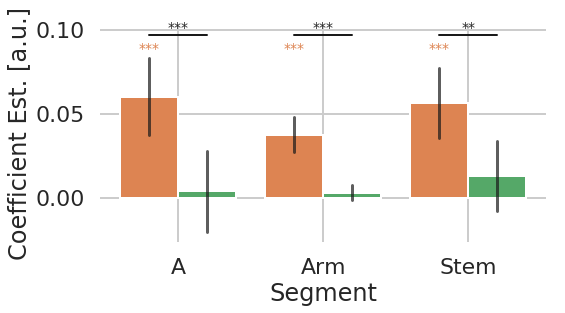

In [136]:
cols = sns.color_palette()[1:3]

m = np.zeros((2,3))
m[0] = mdf['Cue'].params[2:5]
m[1] = mdf['Desc'].params[2:5]

ci = np.zeros((2,3,2))
ci[0] = mdf['Cue'].conf_int()[2:5]
ci[1] = mdf['Desc'].conf_int()[2:5]

f,ax = plt.subplots(1,figsize=(8,4))
x = np.arange(3)
wi=0.4
ax.bar(x-wi/2,m[0],wi,label='Cue',color=cols[0])
ax.bar(x+wi/2,m[1],wi,label='Dec',color=cols[1])
ax.set_xticks(x)
ax.set_xticklabels(['A','Arm','Stem'])

for ii in x:
    ax.plot([ii-wi/2,ii-wi/2],ci[0][ii],linewidth=3,color='k',alpha=0.7)
    ax.plot([ii+wi/2,ii+wi/2],ci[1][ii],linewidth=3,color='k',alpha=0.7)

s = {}
s[0] = getSig(mdf['Cue'].pvalues[2:5])
s[1] = getSig(mdf['Desc'].pvalues[2:5])
s[2] = getSig(mdf['x'].pvalues[6:9])


yup = ax.get_ylim()[1]
for ii in x:
    ax.text(ii-wi/2,yup*1.05,s[0][ii],fontsize=14, horizontalalignment='center', verticalalignment='top',color=cols[0])
    ax.text(ii+wi/2,yup*1.05,s[1][ii],fontsize=14, horizontalalignment='center', verticalalignment='top',color=cols[1])
    if not(s[2][ii]==''):
        ax.plot([ii-wi/2,ii+wi/2],[yup*1.1,yup*1.1],linewidth=2,color='k')
        ax.text(ii,yup*1.1,s[2][ii],fontsize=14,horizontalalignment='center', verticalalignment='bottom')
        
    
ax.set_xlabel('Segment')
ax.set_ylabel('Coefficient Est. [a.u.]')

_=ax.legend(bbox_to_anchor=(1.02,0.1),loc=3,frameon=False)

plotSP = Path('/mnt/c/Users/alexg8/Documents/SfN2019/Plots/')
f.savefig(plotSP / 'SegmentAct2SePerf.svg', bbox_inches='tight', pad_inches=0.2)
ax.legend().remove()
f.savefig(plotSP / 'SegmentAct2SePerf_nl.svg', bbox_inches='tight', pad_inches=0.2)


In [137]:

f = lambda x: np.log( (x+tol) /(1- (x+tol)))
All_UniRes['L_pCoST'] =  f(All_UniRes['pCoST'])

mdf = {}
for c in ['Cue','Desc','Cue_Desc']:
    subset = (All_UniRes['Cond']==c)& (All_UniRes['task']!='T3j')

    dat =[]
    dat = All_UniRes[subset].copy()
    dat = dat[~ ( (dat['T'].isnull()) | (dat['L_pCoST'].isnull () ) )]

    md =smf.mixedlm('L_pCoST ~ Seg:aT + task',data=dat,groups=dat['an'])
    mdf[c] = md.fit()
    print(mdf[c].summary())
    print(mdf[c].wald_test_terms())
    print()

subset = ((All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc')) & (All_UniRes['task']!='T3j')
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = All_UniRes[subset].copy()
dat = dat[~ ( (dat['T'].isnull()) | (dat['L_pCoST'].isnull () ) )]
md =smf.mixedlm('L_pCoST ~ Seg:aT * Cond + task',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())
print()

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: L_pCoST   
No. Observations: 3156    Method:             REML      
No. Groups:       3       Scale:              0.2669    
Min. group size:  543     Likelihood:         -2415.2939
Max. group size:  1491    Converged:          Yes       
Mean group size:  1052.0                                
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     1.926    0.256   7.524 0.000  1.424  2.428
task[T.T3i]  -1.774    0.027 -65.262 0.000 -1.828 -1.721
Seg[A]:aT     0.029    0.014   2.070 0.038  0.002  0.057
Seg[Arm]:aT   0.034    0.006   5.239 0.000  0.021  0.046
Seg[Stem]:aT  0.030    0.013   2.292 0.022  0.004  0.055
Group Var     0.196    0.381                            

                  chi2                  P>chi2  df constraint
Intercept    56.603248  5.332368359

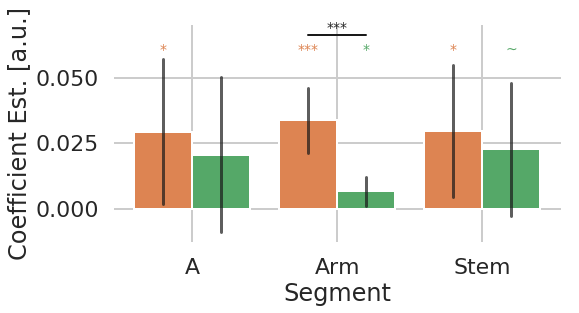

In [138]:
cols = sns.color_palette()[1:3]

m = np.zeros((2,3))
m[0] = mdf['Cue'].params[2:5]
m[1] = mdf['Desc'].params[2:5]

ci = np.zeros((2,3,2))
ci[0] = mdf['Cue'].conf_int()[2:5]
ci[1] = mdf['Desc'].conf_int()[2:5]

f,ax = plt.subplots(1,figsize=(8,4))
x = np.arange(3)
wi=0.4
ax.bar(x-wi/2,m[0],wi,label='Cue',color=cols[0])
ax.bar(x+wi/2,m[1],wi,label='Desc',color=cols[1])
ax.set_xticks(x)
ax.set_xticklabels(['A','Arm','Stem'])

for ii in x:
    ax.plot([ii-wi/2,ii-wi/2],ci[0][ii],linewidth=3,color='k',alpha=0.7)
    ax.plot([ii+wi/2,ii+wi/2],ci[1][ii],linewidth=3,color='k',alpha=0.7)

s = {}
s[0] = getSig(mdf['Cue'].pvalues[2:5])
s[1] = getSig(mdf['Desc'].pvalues[2:5])
s[2] = getSig(mdf['x'].pvalues[6:9])


yup = ax.get_ylim()[1]
for ii in x:
    ax.text(ii-wi/2,yup*1.05,s[0][ii],fontsize=14, horizontalalignment='center', verticalalignment='top',color=cols[0])
    ax.text(ii+wi/2,yup*1.05,s[1][ii],fontsize=14, horizontalalignment='center', verticalalignment='top',color=cols[1])
    if not(s[2][ii]==''):
        ax.plot([ii-wi/2,ii+wi/2],[yup*1.1,yup*1.1],linewidth=2,color='k')
        ax.text(ii,yup*1.1,s[2][ii],fontsize=14,horizontalalignment='center', verticalalignment='bottom')
        
    
ax.set_xlabel('Segment')
ax.set_ylabel('Coefficient Est. [a.u.]')
#_=ax.legend(bbox_to_anchor=(1.02,0.1),loc=3,frameon=False)
#ax.get_legend().remove()
f.savefig(plotSP / 'SegmentAct2SePerfST.svg', bbox_inches='tight', pad_inches=0.2)

Plot all the data by cell and animal.

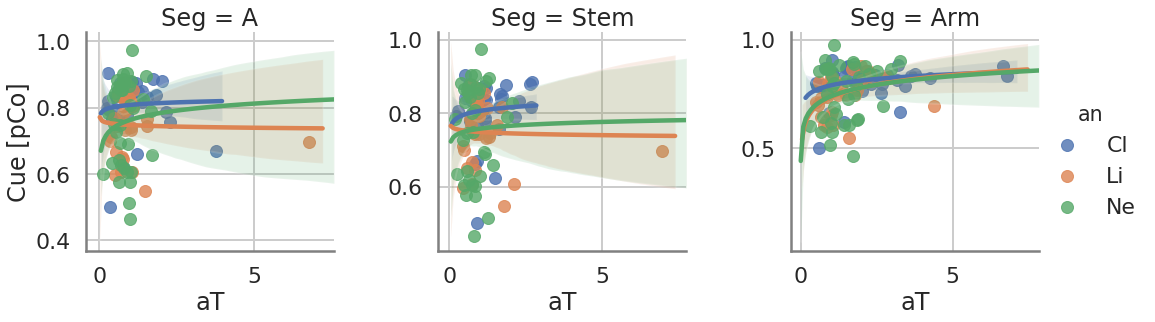

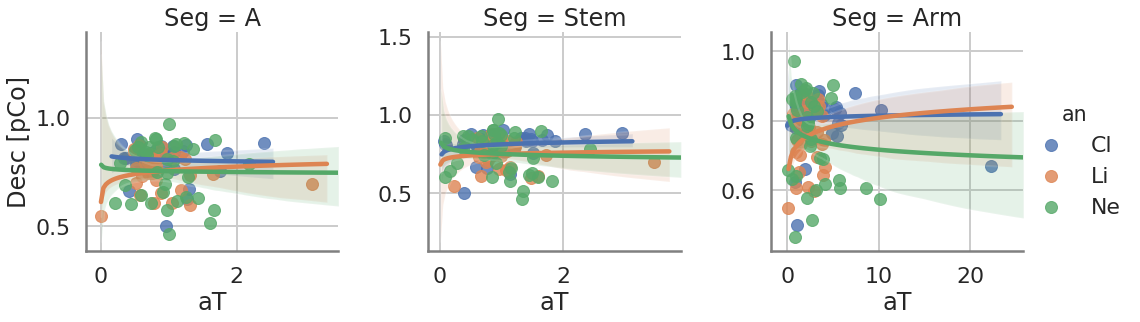

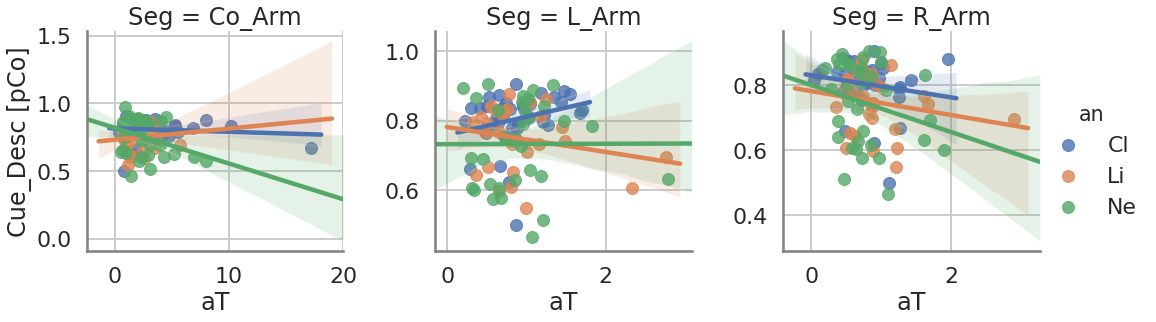

In [385]:
X=All_UniRes.groupby(['se','an','Seg','Cond']).median()
X=X.reset_index()

for c  in ['Cue','Desc']:
    subset = (X['Cond']==c) & (All_UniRes['task']=='T3g')
    ax=sns.lmplot(x='aT',y='pCo',hue='an',col='Seg',logx=True,data=X[subset],col_order=['A','Stem','Arm'],sharex=False,sharey=False)
    ax.set_ylabels(c + ' [pCo]')
    
subset = (X['Cond']=='Cue_Desc')
ax=sns.lmplot(x='aT',y='pCo',hue='an',col='Seg',data=X[subset],col_order=['Co_Arm','L_Arm','R_Arm'],sharex=False,sharey=False)
ax.set_ylabels('Cue_Desc' + ' [pCo]')

## Decoding Results.

## I. Decoding Results by Cell. 

In [427]:
se = 'Ne_T3g_061818'
X = All_DecRes[(All_DecRes['unit']==3)&(All_DecRes['se']==se)]
X = X.loc[:,['Loc','Test','unit','Decoder','BAc','P','Z','-log(P)','se','an','nTrials', 'pCo', 'pCoST', 'uID']]
X.groupby(['Test','Loc','Decoder','an','se']).mean()
X=X.reset_index()
X['Test'] = pd.Categorical(X['Test'],categories=['Model','Cue','Desc'],ordered=True)
X.sort_values('Test',inplace=True)
X['Loc'] = pd.Categorical(X['Loc'],categories=['h','a','center','be','int','cdfg','goal'],ordered=True)
X.sort_values('Loc',inplace=True)


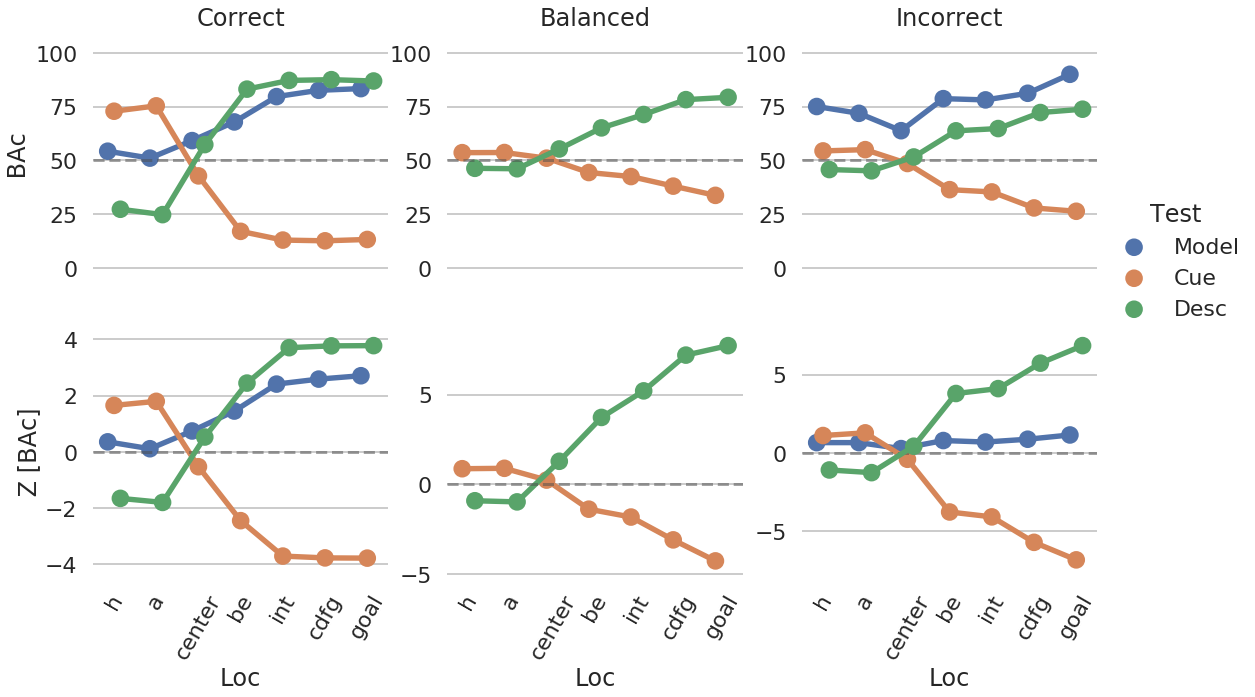

In [429]:
f,ax=SBA.plotMultipleDecoderResults(X)

for a in ax.flatten():
    for tick in a.get_xticklabels():
        tick.set_rotation(60)

for a in ax[0]:
    a.set_xticklabels([])
f.savefig(plotSP / 'Decoder_SingCells.svg', bbox_inches='tight', pad_inches=0.2)


In [387]:
relevant_vars = ['Loc','Test','unit','Decoder','BAc','P','Z','-log(P)','se','an','nTrials', 'pCo', 'pCoST', 'uID']
X = All_DecRes[relevant_vars].copy()
X.groupby(['Test','Loc','Decoder','an','se']).mean()
X=X.reset_index()
X['Test'] = pd.Categorical(X['Test'],categories=['Model','Cue','Desc'],ordered=True)
X.sort_values('Test',inplace=True)
X['Loc'] = pd.Categorical(X['Loc'],categories=['h','a','center','be','int','cdfg','goal'],ordered=True)
X.sort_values('Loc',inplace=True)

X.loc[X['Z']>10,'Z']=10
X.loc[X['Z']<-10,'Z']=-10

subset = (X['nTrials']>100)

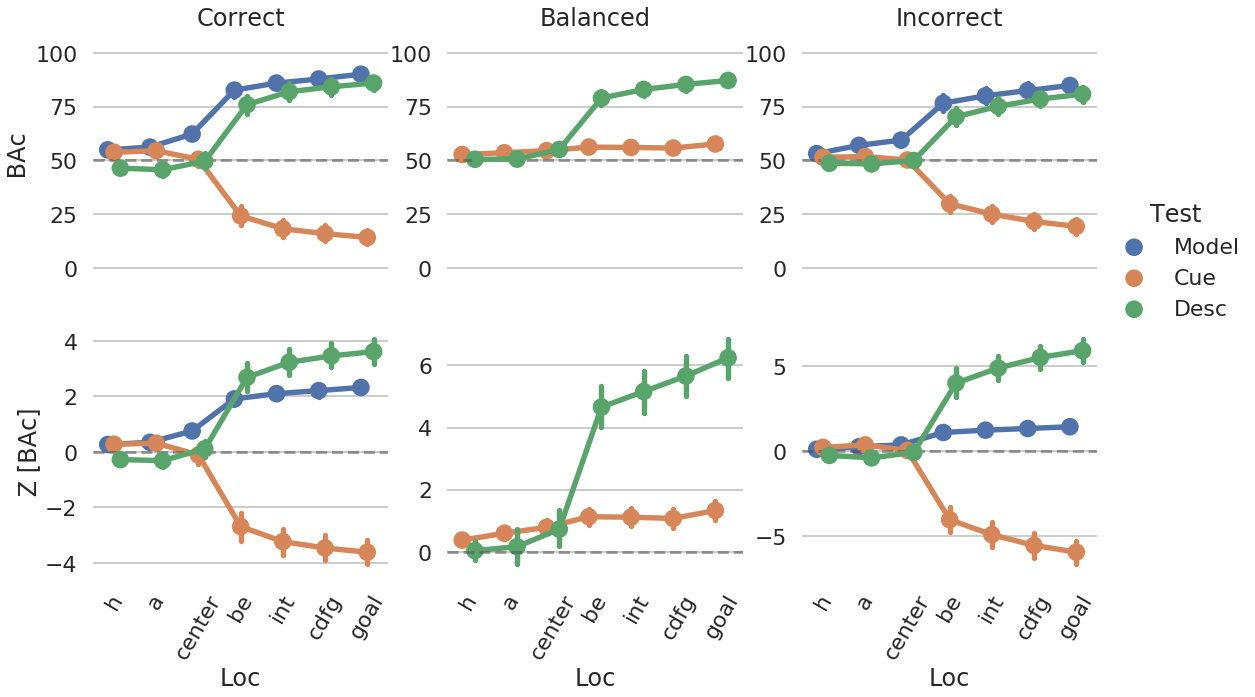

In [433]:

f,ax=SBA.plotMultipleDecoderResults(X,plotAll=False,ci=95)

for a in ax.flatten():
    for tick in a.get_xticklabels():
        tick.set_rotation(60)

for a in ax[0]:
    a.set_xticklabels([])

f.savefig(plotSP / 'Decoder_SingCellsAvg.svg', bbox_inches='tight', pad_inches=0.2)
#_=SBA.plotMultipleDecoderResults(X,plotAll=True,ci=95)

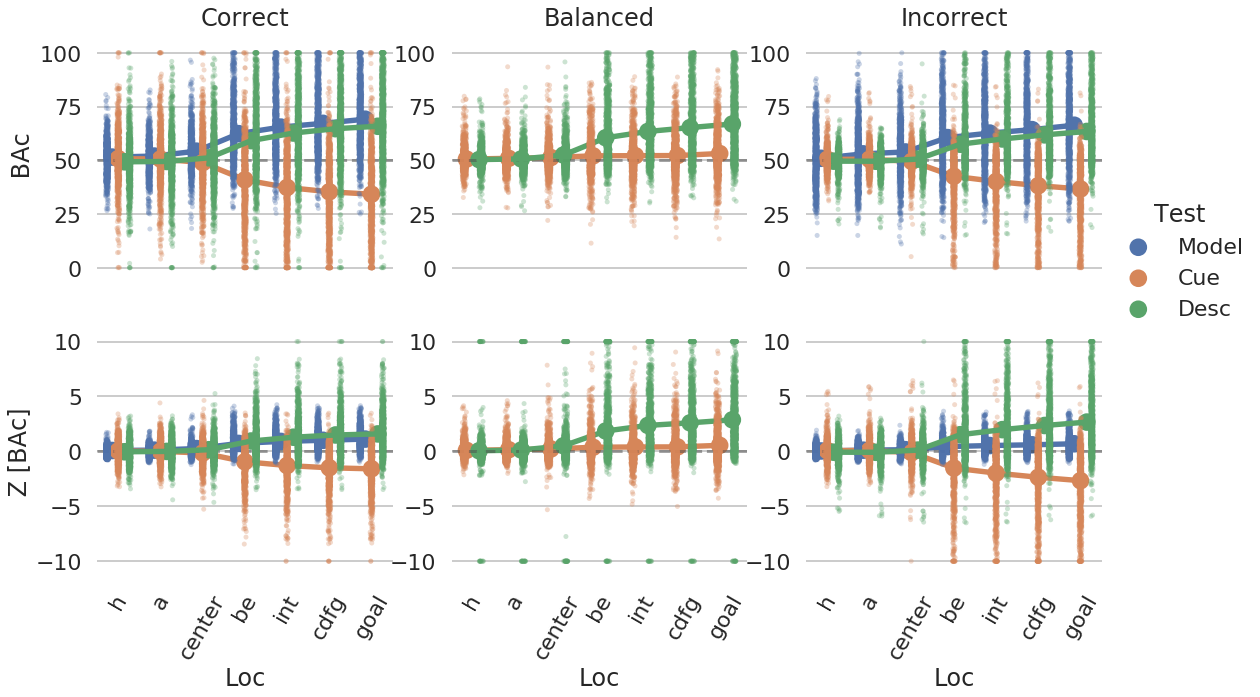

In [388]:

f,ax=SBA.plotMultipleDecoderResults(X,plotAll=True,ci=95)

for a in ax.flatten():
    for tick in a.get_xticklabels():
        tick.set_rotation(60)

for a in ax[0]:
    a.set_xticklabels([])

#f.savefig(plotSP / 'Decoder_SingCellsAvg_all.svg', bbox_inches='tight', pad_inches=0.2)
#_=SBA.plotMultipleDecoderResults(X,plotAll=True,ci=95)

In [16]:
X

,index,Loc,Test,Decoder,se,an,Unnamed: 0.1,BAc,P,Z,-log(P),nTrials,pCo,pCoST
0,3641,h,Desc,Incorrect,Li_T3g_072618,Li,2,45.788043,0.820424,-0.912247,0.244720,137,0.744526,0.786408
1,3317,h,Cue,Correct,Li_T3g_071118,Li,1,55.000000,0.547004,0.390773,0.657654,51,0.607843,0.761905
2,3318,h,Cue,Correct,Li_T3g_072518,Li,1,72.531746,0.064678,2.297964,3.183296,153,0.803922,0.794521
3,3319,h,Cue,Correct,Li_T3g_072618,Li,1,46.261574,0.759200,-0.343932,0.296540,137,0.744526,0.786408
4,3320,h,Cue,Correct,Li_T3g_073018,Li,1,55.151584,0.428396,0.581420,1.083728,110,0.727273,0.745763
5,3321,h,Cue,Correct,Li_T3g_080118,Li,1,32.875000,0.892071,-0.643773,0.128387,42,0.785714,0.727273
6,3355,h,Cue,Incorrect,Cl_T3g_012319,Cl,1,52.918851,0.296400,0.791184,1.355783,144,0.875000,0.937500
7,3356,h,Cue,Incorrect,Cl_T3g_012419,Cl,1,49.105850,0.635200,-0.254986,0.581573,207,0.884058,0.888889
8,3357,h,Cue,Incorrect,Cl_T3g_012519,Cl,1,48.915786,0.653200,-0.308615,0.623928,200,0.905000,0.936842
9,3358,h,Cue,Incorrect,Cl_T3g_012919,Cl,1,53.125723,0.287184,0.870514,1.595909,205,0.873171,0.916667


## II. Population decoding results.

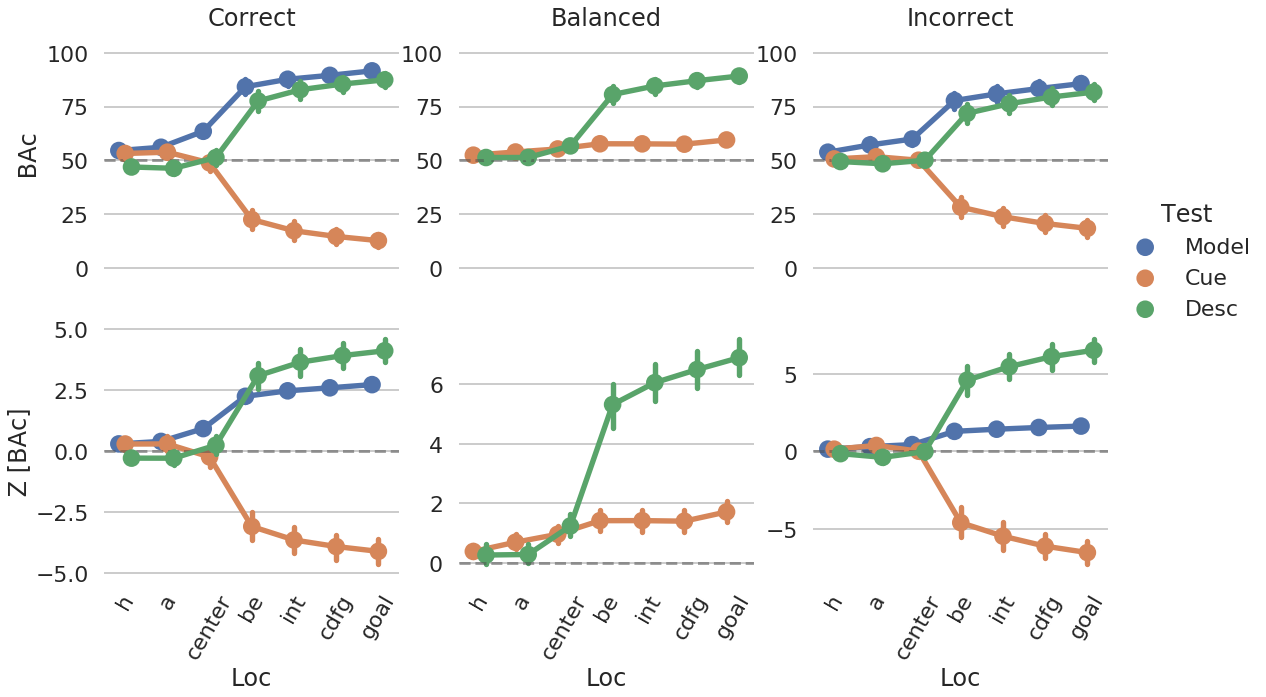

In [432]:
relevant_vars = ['Loc','Test','unit','Decoder','BAc','P','Z','-log(P)','se','an','nTrials', 'pCo', 'pCoST', 'uID']

X = All_PopSumDecRes.copy()
X.loc[X['Z']>10,'Z']=10
X.loc[X['Z']<-10,'Z']=-10

subset = (X['nSeUnits']>=2) & (X['nTrials']>80)
f,ax=SBA.plotMultipleDecoderResults(X[subset],plotAll=False,ci=95)

for a in ax.flatten():
    for tick in a.get_xticklabels():
        tick.set_rotation(60)

for a in ax[0]:
    a.set_xticklabels([])

f.savefig(plotSP / 'Decoder_PopAvg.svg', bbox_inches='tight', pad_inches=0.2)
#_=SBA.plotMultipleDecoderResults(X,plotAll=True,ci=95)
#_=SBA.plotMultipleDecoderResults(X,plotAll=True,ci=95)


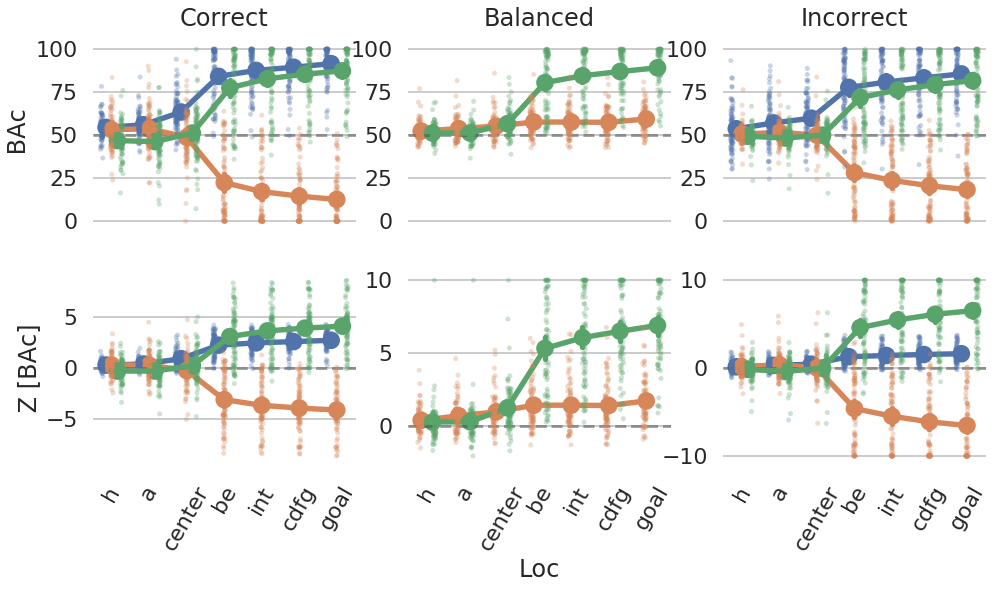

In [431]:
X = All_PopSumDecRes.groupby(['Loc','Test','Decoder','se','an']).mean()
X = X.reset_index()
X['Test'] = pd.Categorical(X['Test'],categories=['Model','Cue','Desc'],ordered=True)
X.sort_values('Test',inplace=True)
X['Loc'] = pd.Categorical(X['Loc'],categories=['h','a','center','be','int','cdfg','goal'],ordered=True)
X.sort_values('Loc',inplace=True)
X.loc[X['Z']>10,'Z']=10
X.loc[X['Z']<-10,'Z']=-10

subset = (X['nSeUnits']>=2) & (X['nTrials']>80)

f,ax = SBA.plotMultipleDecoderResults(X[subset],plotAll=True,ci=95)

for a in ax.flatten():
    for tick in a.get_xticklabels():
        tick.set_rotation(60)
    a.legend().remove()
for a in ax[0]:
    a.set_xticklabels([])

ax[1,0].set_xlabel('')
ax[1,2].set_xlabel('')
f.set_size_inches(16,8)
f.savefig(plotSP / 'Decoder_PopAvgThr.svg', bbox_inches='tight', pad_inches=0.2)


In [303]:
len(X[subset]['se'].unique())

74

No handles with labels found to put in legend.


KendalltauResult(correlation=0.11388329979879276, pvalue=0.16010834667611085)
KendalltauResult(correlation=0.09905377284894148, pvalue=0.22204888646886312)


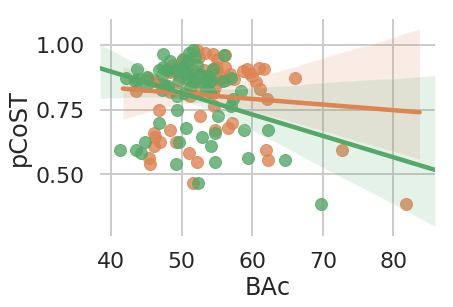

In [160]:
#subset = (X['nSeUnits']>=5) & (X['nTrials']>100) & (X['Loc']=='a')
tol = 0.001
pCo = All_PopSumDecRes.groupby('se').mean()['pCo']
pCoST = All_PopSumDecRes.groupby('se').mean()['pCoST']
C = pd.DataFrame()
CS = pd.DataFrame()

f = lambda x: np.log( (x+tol) /(1- (x+tol)))


subset = (X['Loc']=='a') & (X['Decoder']=='Balanced') &  (X['nTrials']>100)

f,ax = plt.subplots(figsize=(6,4))
subset1 = subset & (X['Test']=='Cue')
ax=sns.regplot(x='BAc',y='pCoST',data=X[subset1],color=cols[0],ax=ax)
subset2 = subset & (X['Test']=='Desc')
ax=sns.regplot(x='BAc',y='pCoST',data=X[subset2],color=cols[1],ax=ax)

,#scatter_kws={'alpha':0.3})
plt.legend().remove()
print(stats.kendalltau(X[subset1]['BAc'],X[subset1]['pCo']))
print(stats.kendalltau(X[subset1]['BAc'],X[subset1]['pCoST']))

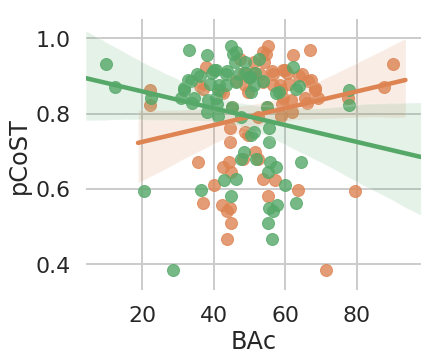

In [154]:
subset = (X['Loc']=='a') & (X['Decoder']=='Correct') &  (X['nTrials']>80)

f,ax = plt.subplots(figsize=(6,5))
subset1 = subset & (X['Test']=='Cue')
ax=sns.regplot(x='BAc',y='pCoST',data=X[subset1],robust=False,color=cols[0],ax=ax)
subset2 = subset & (X['Test']=='Desc')
ax=sns.regplot(x='BAc',y='pCoST',data=X[subset2],robust=False,color=cols[1],ax=ax)




In [156]:
stats.kendalltau(X[subset1]['Z'],X[subset1]['pCoST']), stats.kendalltau(X[subset1]['BAc'],X[subset1]['pCoST'])


(KendalltauResult(correlation=0.16789196942550136, pvalue=0.030801218288551948),
 KendalltauResult(correlation=0.1843050336463243, pvalue=0.017751735035503008))

In [147]:
stats.kendalltau(X[subset1]['BAc'].values-X[subset2]['BAc'].values,X[subset1]['pCoST'].values)

KendalltauResult(correlation=0.14415142552813434, pvalue=0.07556080764195594)

## III. Identifying cells based on their decoding patterns.


In [560]:
relevant_vars = ['Loc','Test','unit','Decoder','BAc','P','Z','-log(P)','se','an','nTrials', 'pCo', 'pCoST', 'uID']
X = All_DecRes[relevant_vars].copy()
X.groupby(['Test','Loc','Decoder','an','se']).mean()
X=X.reset_index()
X['Test'] = pd.Categorical(X['Test'],categories=['Model','Cue','Desc'],ordered=True)
X.sort_values('Test',inplace=True)
X['Loc'] = pd.Categorical(X['Loc'],categories=['h','a','center','be','int','cdfg','goal'],ordered=True)
X.sort_values('Loc',inplace=True)

X.loc[X['Z']>10,'Z']=10
X.loc[X['Z']<-10,'Z']=-10

### corrrect model

number of units showing Cue coding in segment a: 20 / 873 = 0.023
number of units showing Cue coding in segment cdfg: 1 / 873 = 0.001
number of units showing Desc coding in segment a: 21 / 873 = 0.024
number of units showing Desc coding in segment cdfg: 255 / 872 = 0.292
Relationship to Univariate Results


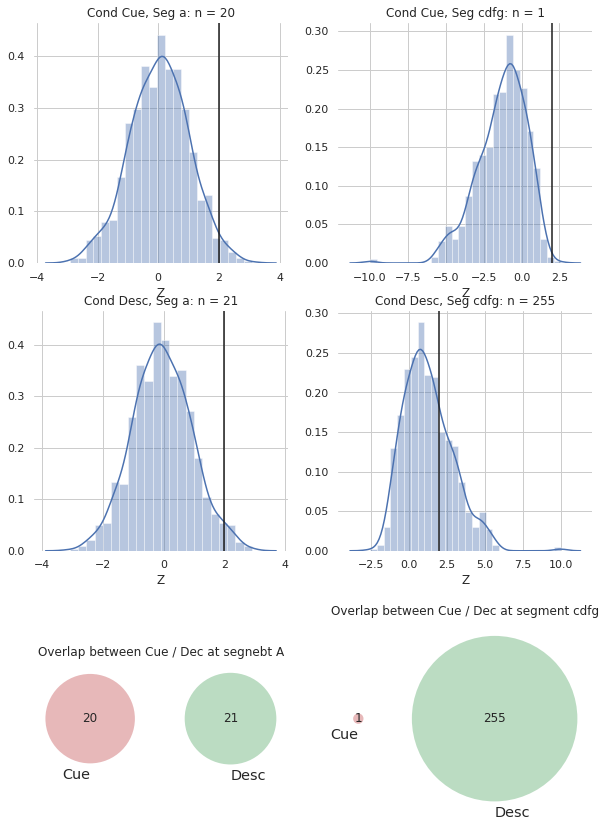

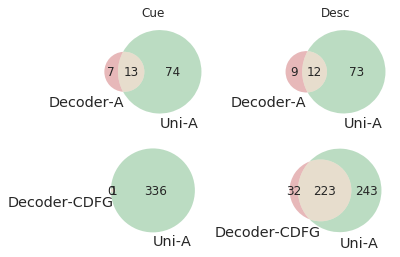

In [572]:

model = 'Correct'
subset = (X['Decoder']==model) 
Y = X[subset].copy()
Y = Y[~Y['Z'].isnull()]

thr = 2
Segs = ['a','cdfg']
Conds = ['Cue','Desc']

DecCellSets = {}

f,ax = plt.subplots(3,2,figsize=(10,15))
ax=ax.flatten()
cnt=0
for cond in Conds:
    DecCellSets[cond] = {}
    for s in Segs:
        subset = (Y['Loc']==s) & (Y['Test']==cond)

        ax[cnt]=sns.distplot(Y[subset]['Z'],ax=ax[cnt])

        #ax[cnt].axvline(-thr,color='k')
        ax[cnt].axvline(thr,color='k')

        x= Y[subset]['Z']>thr
        DecCellSets[cond][s] = set(Y[subset]['uID'][x].values)
        ax[cnt].set_title('Cond {}, Seg {}: n = {}'.format(cond,s,np.sum(x)))

        print( 'number of units showing {0} coding in segment {1}: {2} / {3} = {4:.3f}'.format(cond,s,np.sum(x),len(x),np.mean(x)))
        cnt+=1
    
plt.sca(ax[4])
ax[4].set_title('Overlap between Cue / Dec at segnebt A')
#_=venn3([ CellSets[cond]['A'], CellSets[cond]['Stem']],set_labels=Segs)
_=venn2([DecCellSets['Cue']['a'],DecCellSets['Desc']['a']],set_labels=['Cue','Desc'])
plt.sca(ax[5])
_=venn2([DecCellSets['Cue']['cdfg'],DecCellSets['Desc']['cdfg']],set_labels=['Cue','Desc'])
ax[5].set_title('Overlap between Cue / Dec at segment cdfg')


f,ax=plt.subplots(2,2)
ax = ax.flatten()
plt.sca(ax[0])
_=venn2([DecCellSets['Cue']['a'],UniCellSets['Cue']['A']],set_labels=['Decoder-A','Uni-A'])
ax[0].set_title('Cue')

plt.sca(ax[1])
_=venn2([DecCellSets['Desc']['a'],UniCellSets['Desc']['A']],['Decoder-A','Uni-A'])
ax[1].set_title('Desc')

plt.sca(ax[2])
_=venn2([DecCellSets['Cue']['cdfg'],UniCellSets['Cue']['Arm']],['Decoder-CDFG','Uni-A'])

plt.sca(ax[3])
_=venn2([DecCellSets['Desc']['cdfg'],UniCellSets['Desc']['Arm']],['Decoder-CDFG','Uni-A'])
print('Relationship to Univariate Results')

number of units showing Cue coding in segment a: 20 / 920 = 0.022
number of units showing Cue coding in segment cdfg: 128 / 920 = 0.139
number of units showing Desc coding in segment a: 17 / 913 = 0.019
number of units showing Desc coding in segment cdfg: 422 / 910 = 0.464
Relationship to Univariate Results


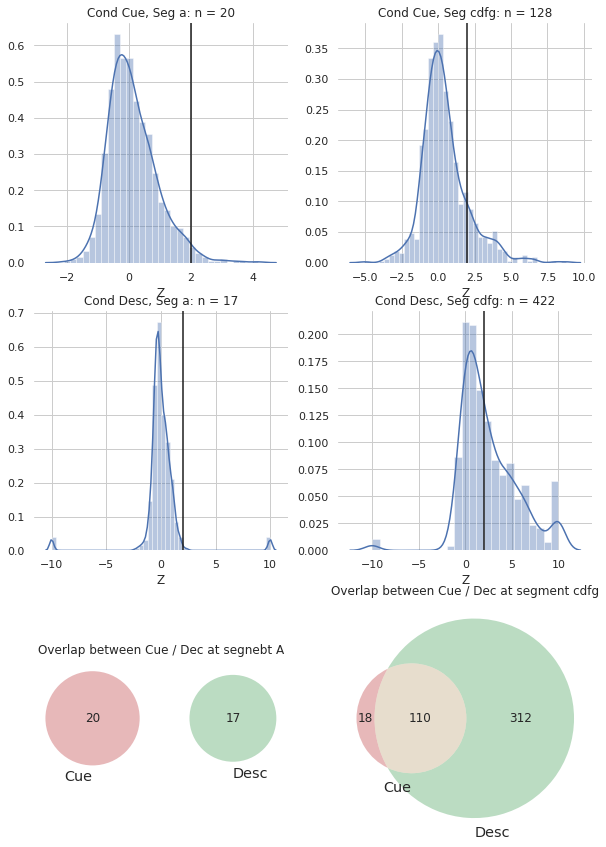

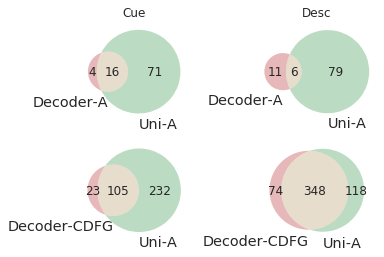

In [573]:
model = 'Balanced'
subset = (X['Decoder']==model) 
Y = X[subset].copy()
Y = Y[~Y['Z'].isnull()]

thr = 2
Segs = ['a','cdfg']
Conds = ['Cue','Desc']

DecCellSets = {}

f,ax = plt.subplots(3,2,figsize=(10,15))
ax=ax.flatten()
cnt=0
for cond in Conds:
    DecCellSets[cond] = {}
    for s in Segs:
        subset = (Y['Loc']==s) & (Y['Test']==cond)

        ax[cnt]=sns.distplot(Y[subset]['Z'],ax=ax[cnt])

        #ax[cnt].axvline(-thr,color='k')
        ax[cnt].axvline(thr,color='k')

        x= Y[subset]['Z']>thr
        DecCellSets[cond][s] = set(Y[subset]['uID'][x].values)
        ax[cnt].set_title('Cond {}, Seg {}: n = {}'.format(cond,s,np.sum(x)))

        print( 'number of units showing {0} coding in segment {1}: {2} / {3} = {4:.3f}'.format(cond,s,np.sum(x),len(x),np.mean(x)))
        cnt+=1
    
plt.sca(ax[4])
ax[4].set_title('Overlap between Cue / Dec at segnebt A')
#_=venn3([ CellSets[cond]['A'], CellSets[cond]['Stem']],set_labels=Segs)
_=venn2([DecCellSets['Cue']['a'],DecCellSets['Desc']['a']],set_labels=['Cue','Desc'])
plt.sca(ax[5])
_=venn2([DecCellSets['Cue']['cdfg'],DecCellSets['Desc']['cdfg']],set_labels=['Cue','Desc'])
ax[5].set_title('Overlap between Cue / Dec at segment cdfg')

f,ax=plt.subplots(2,2)
ax = ax.flatten()
plt.sca(ax[0])
_=venn2([DecCellSets['Cue']['a'],UniCellSets['Cue']['A']],set_labels=['Decoder-A','Uni-A'])
ax[0].set_title('Cue')

plt.sca(ax[1])
_=venn2([DecCellSets['Desc']['a'],UniCellSets['Desc']['A']],['Decoder-A','Uni-A'])
ax[1].set_title('Desc')

plt.sca(ax[2])
_=venn2([DecCellSets['Cue']['cdfg'],UniCellSets['Cue']['Arm']],['Decoder-CDFG','Uni-A'])

plt.sca(ax[3])
_=venn2([DecCellSets['Desc']['cdfg'],UniCellSets['Desc']['Arm']],['Decoder-CDFG','Uni-A'])
print('Relationship to Univariate Results')

In [576]:
DecCellSets['Cue']['a']

{51,
 90,
 159,
 181,
 187,
 276,
 278,
 370,
 499,
 571,
 579,
 784,
 800,
 808,
 813,
 818,
 886,
 898,
 905,
 910}

In [607]:
XX=All_DecRes.groupby(['an','se','uID']).mean()
XX = XX.reset_index()
XX=XX.set_index('uID')

#sets = DecCellSets['Desc']['a']
sets = UniCellSets['Desc']['Arm']
counts =  XX.loc[sets]['an'].value_counts()
totals = XX['an'].value_counts()
ratios = counts/totals
pd.DataFrame([counts,ratios,totals],index=['counts','ratio','totals']).T

,counts,ratio,totals
Li,233.0,0.495745,470.0
Ne,129.0,0.470803,274.0
Cl,104.0,0.559140,186.0


Li    470
Ne    274
Cl    186
Name: an, dtype: int64

In [227]:
BAc=X.set_index('uID').pivot_table(index='uID',columns=['Decoder','Test','Loc'],values='BAc',aggfunc='mean')
Z=X.set_index('uID').pivot_table(index='uID',columns=['Decoder','Test','Loc'],values='Z',aggfunc='mean')
goodCells = np.isnan(Z.values).sum(axis=1)==0
BAc = BAc[goodCells]
Z = Z[goodCells]

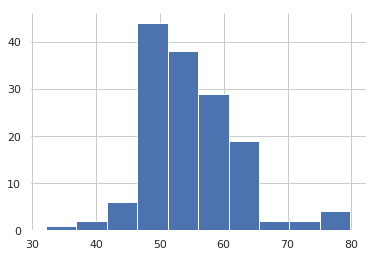

In [247]:
mod = 'Balanced'
loc = 'goal'
c = 'Cue'
subset = Z.loc[:,(mod,c,loc)]>2
_=plt.hist(BAc.loc[subset,('Balanced','Cue','center')])


In [275]:
subset = (X['Decoder']=='Incorrect')
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = X[subset]
dat = dat[~dat['Z'].isnull()]

tol = 0.001
f = lambda x: np.log( (x+tol) /(1- (x+tol)))
dat['L_pCo'] =  f(dat['pCo'])

md =smf.mixedlm('L_pCo ~  Z+Test + Z:Test:Loc  ',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     L_pCo     
No. Observations:      16507       Method:                 REML      
No. Groups:            3           Scale:                  0.1513    
Min. group size:       3541        Likelihood:             -7922.9949
Max. group size:       9281        Converged:              Yes       
Mean group size:       5502.3                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.524    0.106 14.418 0.000  1.316  1.731
Test[T.Cue]                -0.015    0.008 -1.864 0.062 -0.032  0.001
Test[T.Desc]               -0.015    0.008 -1.864 0.062 -0.032  0.001
Z                          -0.009    0.024 -0.373 0.709 -0.056  0.038
Z:Loc[T.a]                 -0.005   

In [529]:
13*20


260

In [155]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [219]:
ypca = PCA(n_components=5).fit_transform(Y[goodCells].T)

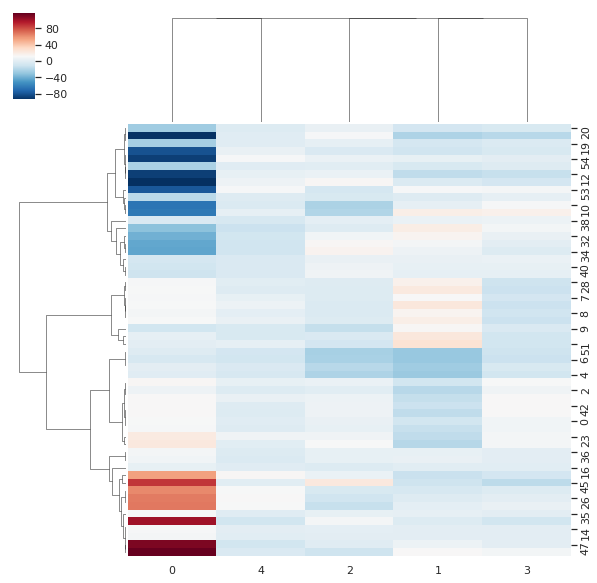

In [220]:
#sns.clustermap(Y.corr(),metric='correlation',cmap = 'RdBu_r')
sns.clustermap(ypca,metric='correlation',cmap = 'RdBu_r')

In [280]:
pCo[goodCells].shape

(769,)

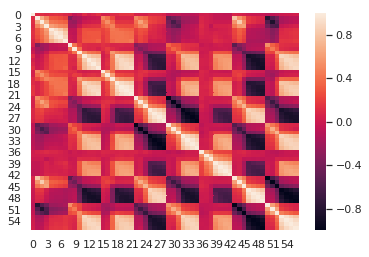

In [287]:
sns.heatmap(np.corrcoef(pCo[goodCells],Z.values.T))

## IV. Population Relationship to Session Accuracy.

In [148]:
tol = 0.001
subset = (X['nSeUnits']>=2) & (X['nTrials']>80)

pCo = All_PopSumDecRes[subset].groupby('se').mean()['pCo']
pCoST = All_PopSumDecRes[subset].groupby('se').mean()['pCoST']
C = pd.DataFrame()
CS = pd.DataFrame()

f = lambda x: np.log( (x+tol) /(1- (x+tol)))

xxxx = All_PopSumDecRes[subset].set_index('se').pivot_table(index='se',columns=['Decoder','Test','Loc'],values='BAc',aggfunc='mean')
xxxx = xxxx.T.reindex(['h','a','center','be','int','cdfg','goal'],level='Loc').T
xxxx['pCo'] = f(pCo)
xxxx['pCoST'] = f(pCoST)
C['BAc'] = xxxx.corr(method='spearman')['pCo']
CS['BAc'] = xxxx.corr(method='spearman')['pCoST']


xxxx['pCoST'] = f(pCoST)

xxxx = All_PopSumDecRes.set_index('se').pivot_table(index='se',columns=['Decoder','Test','Loc'],values='Z',aggfunc='mean')
xxxx = xxxx.T.reindex(['h','a','center','be','int','cdfg','goal'],level='Loc').T
xxxx['pCo'] = f(pCo)
xxxx['pCoST'] = f(pCoST)
C['Z'] = xxxx.corr(method='spearman')['pCo']
CS['Z'] = xxxx.corr(method='spearman')['pCoST']


TypeError: cannot insert an item into a CategoricalIndex that is not already an existing category

In [332]:
tol = 0.001
f = lambda x: np.log( (x+tol) /(1- (x+tol)))
subset = (All_PopSumDecRes['nSeUnits']>=5) & (All_PopSumDecRes['nTrials']>=100)

pCo = All_PopSumDecRes.groupby('se').mean()['pCo']
pCoST = All_PopSumDecRes.groupby('se').mean()['pCoST']

pCo = pCo[selSes]
pCoST = pCoST[selSes]

X_BAc = All_PopSumDecRes.pivot_table(index='se',columns=['Decoder','Test','Loc'],values='BAc',aggfunc='mean')
X_BAc = X_BAc.loc[selSes]
X_Z = All_PopSumDecRes.pivot_table(index='se',columns=['Decoder','Test','Loc'],values='Z',aggfunc='mean')
X_Z = X_Z.loc[selSes]

C=pd.DataFrame(0,index=['BAc','Z'],columns=X_BAc.columns)
CS=pd.DataFrame(0,index=['BAc','Z'],columns=X_BAc.columns)

Y=pd.DataFrame(X_BAc.values,index=X_BAc.index)
Y.loc[:,'pCo']=pCo
C.loc['BAc']=Y.corr(method='kendall')['pCo'].values[:-1]

Y=pd.DataFrame(X_Z.values,index=X_BAc.index)
Y.loc[:,'pCo']=pCo
C.loc['Z']=Y.corr(method='kendall')['pCo'].values[:-1]

Y=pd.DataFrame(X_BAc.values,index=X_BAc.index)
Y.loc[:,'pCoST']=pCoST
CS.loc['BAc']=Y.corr(method='kendall')['pCoST'].values[:-1]

Y=pd.DataFrame(X_Z.values,index=X_BAc.index)
Y.loc[:,'pCoST']=pCoST
CS.loc['Z']=Y.corr(method='kendall')['pCoST'].values[:-1]
C = C.T
CS = CS.T


In [325]:
#X_BAc = All_PopSumDecRes[subset].pivot_table(index='se',columns=['Decoder','Test','Loc'],values='BAc',aggfunc='mean')
#X_BAc
selSes = All_PopSumDecRes[subset]['se'].unique()#.pivot_table(index='se',columns=['Decoder','Test','Loc'],values='BAc',aggfunc='mean')


Decoder         Balanced                                              \
Test                 Cue                                               
Loc                    h          a     center         be        int   
se                                                                     
Li_T3g_070618  50.082038  46.139580  46.136792  48.794467  46.658530   
Ne_T3i_073018  52.238360  52.630953  55.111416  57.655121  56.701300   
Ne_T3i_072618  48.997635  52.152129  52.853492  63.355628  58.006222   
Ne_T3i_072518  51.246021  49.224260  46.797501  45.179942  43.362938   
Ne_T3i_071118  45.564935  47.214483  44.347296  47.639340  51.458840   
Ne_T3i_071018  47.257335  48.399753  52.612208  58.747635  61.853888   
Ne_T3i_070218  50.654849  46.027346  46.359246  51.685526  52.734506   
Ne_T3i_080318  45.519509  46.855037  45.680131  49.939887  52.086351   
Ne_T3i_062918  50.935175  46.094338  46.507365  57.254318  62.867985   
Ne_T3i_060618  61.283700  54.639235  53.640160  56.309509  56.368438   
Ne_T3i_061118  66.916667  62.250000  66.333333  66.833333  64.166667   
Cl_T3g_010619  47.936814  58.721181  55.809838  72.513892  68.318136   
Cl_T3g_010819  51.405940  53.946417  53.786674  58.991808  62.806764   
Cl_T3g_021419  60.566230  60.185388  57.802110  58.869175  56.652022   
Cl_T3i_021519  48.881264  45.369729  49.858072  53.252831  56.942456   
Cl_T3g_122118  48.043238  54.414284  56.698232  52.022851  55.809222   
Ne_T3g_053118  52.511261  52.419262  52.339826  65.083642  68.298113   
Li_T3g_070218  55.604435  53.826518  57.530582  62.301241  61.358450   
Li_T3g_062818  58.349118  66.115394  65.973954  60.117217  58.636119   
Li_T3g_062718  49.949464  48.289952  53.765480  53.377525  51.895267   
Cl_T3g_122018  50.077195  53.194407  51.420336  52.387430  52.724883   
Ne_T3g_052918  51.622400  53.301830  55.100204  64.538907  64.825359   
Cl_T3g_020419  52.676338  51.638773  50.022851  50.748918  51.560593   
Ne_T3g_070918  48.141955  48.752877  49.367399  51.650654  52.320018   
Ne_T3g_062518  55.351402  60.989439  60.238712  57.442831  53.578907   
Ne_T3g_062018  43.696368  43.570258  43.020789  42.647291  42.639942   
Ne_T3g_061818  52.559673  51.583786  51.249603  61.076521  62.263214   
Ne_T3g_061518  51.206074  54.465832  53.648703  49.540874  47.372367   
Ne_T3g_061218  50.722542  56.868385  58.492671  63.572724  67.030476   
Ne_T3g_060418  51.389945  52.119293  54.634853  71.463755  73.236003   
...                  ...        ...        ...        ...        ...   
Li_T3g_053018  52.740853  54.398215  53.785294  54.531544  53.656986   
Li_T3g_053118  50.285831  51.342514  52.184448  53.749332  54.124178   
Li_T3g_060118  50.309566  49.447635  52.398254  51.466576  51.564063   
Cl_T3g_012519  49.492372  50.084776  50.281530  47.813898  47.502428   
Cl_T3g_012419  48.715810  59.725069  69.659790  72.884941  69.408225   
Cl_T3g_012319  51.477533  50.627806  55.666564  58.504714  58.423909   
Cl_T3g_012219  52.215519  54.850287  53.508023  47.375596  46.915782   
Cl_T3g_011819  50.471837  54.114993  63.144042  70.653484  67.901944   
Cl_T3g_011619  50.390454  55.358151  68.522008  62.182503  61.044453   
Cl_T3g_011519  47.921699  55.061481  57.813741  63.844900  65.693191   
Cl_T3g_011419  53.521171  56.095766  56.378688  56.191154  53.870408   
Cl_T3g_010919  50.753714  54.970691  57.365116  54.355562  51.410972   
Cl_T3g_013019  58.982783  61.592961  61.609969  67.896609  77.367052   
Li_T3g_071018  57.870398  61.034951  57.620050  56.539637  58.127415   
Li_T3g_062618  53.543925  46.832525  55.788753  56.661693  58.108545   
Li_T3g_062518  50.222261  45.548306  47.117307  52.286649  57.182637   
Li_T3g_062018  56.248356  54.683023  60.205863  62.136612  62.623253   
Li_T3g_061818  48.448063  56.218645  60.896573  62.662038  59.461780   
Li_T3g_061518  43.215977  45.471386  51.108056  49.713010  46.654672   
Li_T3g_061318  52.232824  57.113490  56.480444  57.213543  53.860043   
Li_T3g_060418  49.089187  52.421288  54.

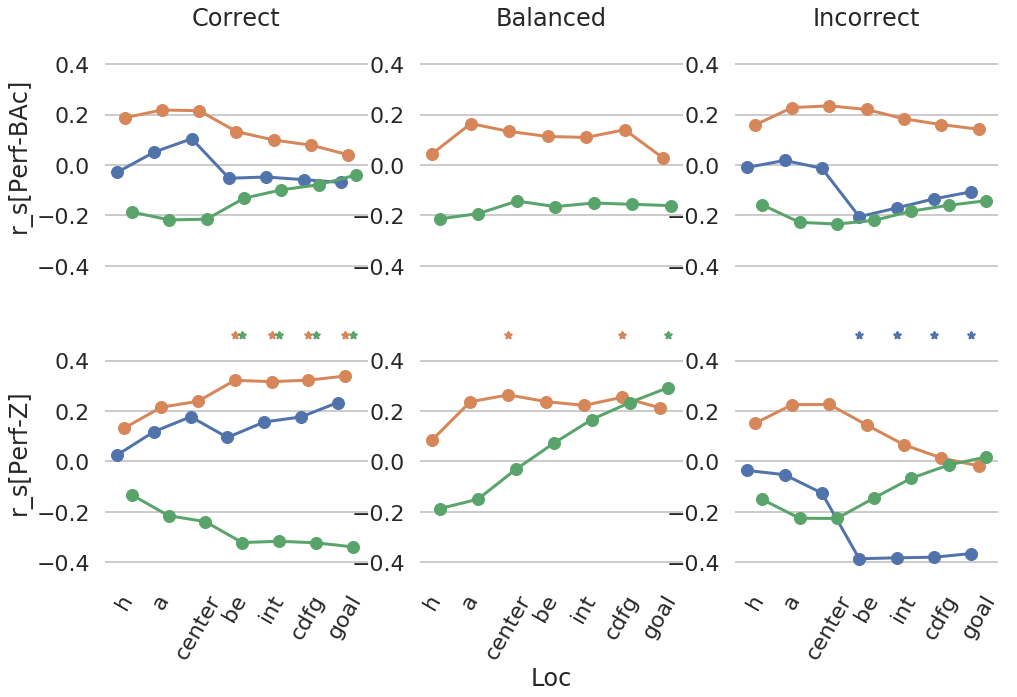

In [341]:
pal =sns.color_palette(desat=.9)[:3]
f,ax = plt.subplots(2,3,figsize=(16,12))
lw =3
n = len(pCoST)
P = np.abs(np.arctanh(C)*np.sqrt((n-3)/1.06))>2
x=np.arange(7)
locs = ['h','a','center','be','int','cdfg','goal']
ii = 0
for tt in ['BAc','Z']:
    jj = 0
        
    for model in ['Correct','Balanced','Incorrect']:
        if model!='Balanced':
            ax[ii,jj].plot(x-0.2,C.loc[(model,'Model'),tt],color=pal[0],label = 'Model',linewidth=lw,marker = 'o')
            cnt=0
            for i in P.loc[(model,'Model'),tt]:
                if i:
                    ax[ii,jj].scatter(cnt-0.2,0.5,50,marker='*',color=pal[0])
                cnt+=1
        # Cue   
        ax[ii,jj].plot(x,C.loc[(model,'Cue'),tt],color=pal[1],label = 'Cue',linewidth=lw,marker = 'o')
        cnt=0
        for i in P.loc[(model,'Cue'),tt]:
            if i:
                ax[ii,jj].scatter(cnt,0.5,50,marker='*',color=pal[1])
            cnt+=1
        
        # Dec
        ax[ii,jj].plot(x+0.2,C.loc[(model,'Desc'),tt],color=pal[2],label = 'Dec',linewidth=lw,marker = 'o')
        cnt=0
        for i in P.loc[(model,'Desc'),tt]:
            if i:
                ax[ii,jj].scatter(cnt+0.2,0.5,50,marker='*',color=pal[2])
            cnt+=1
            
        ax[ii,jj].set_ylim([-0.45,0.53])
        if ii==0:
            ax[ii,jj].set_title(model)
        jj+=1
        
        ax[ii,0].set_ylabel('r_s[Perf-{}]'.format(tt))
    ii+=1
for ii in np.arange(2):
    for jj in np.arange(3):
        ax[ii,jj].set_xticks(x)
        ax[ii,jj].set_xticklabels(locs)
ax[1,1].set_xlabel('Loc')
#ax[1,2].legend(labels = ['Model','Cue','Dec'],loc=3,bbox_to_anchor=[1.03,0],frameon=False)

for a in ax.flatten():
    for tick in a.get_xticklabels():
        tick.set_rotation(60)
    a.xaxis.grid(0)
for a in ax[0]:
    a.set_xticklabels([])

f.set_size_inches(16,10)
f.savefig(plotSP / 'Decoder_Pop2PerfCorr.svg', bbox_inches='tight', pad_inches=0.2)

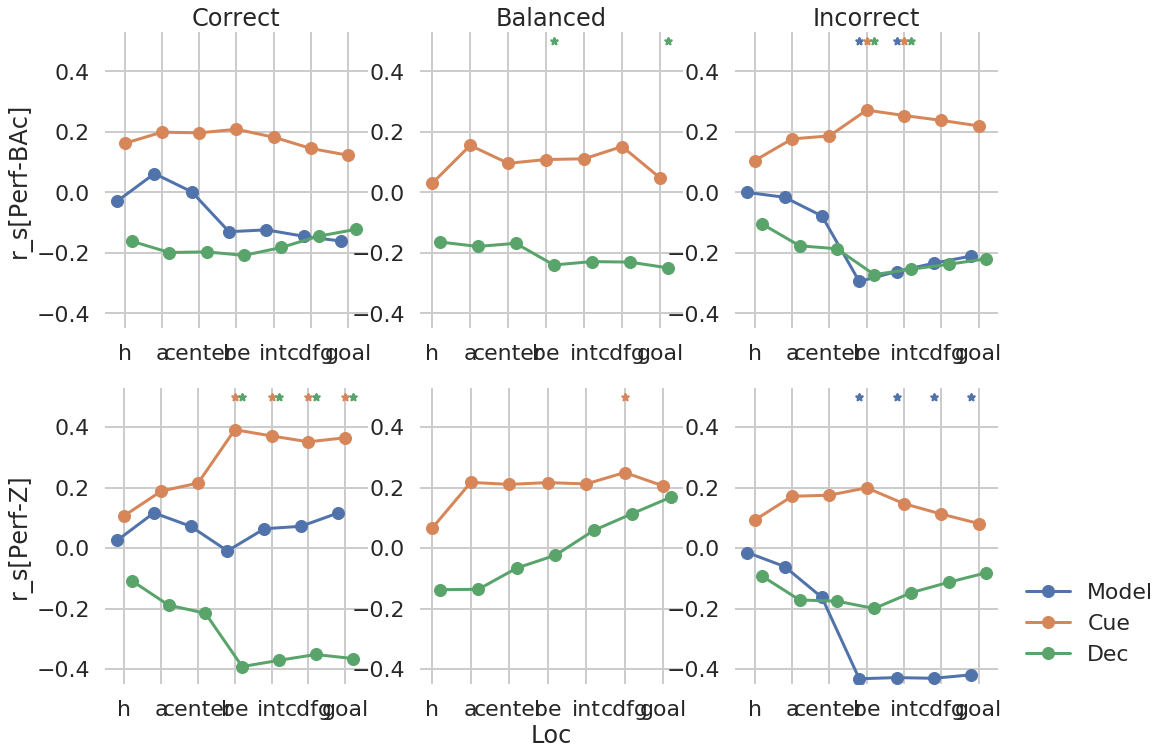

In [334]:
pal =sns.color_palette(desat=.9)[:3]
f,ax = plt.subplots(2,3,figsize=(16,12))
lw =3
n = len(pCoST)
P = np.abs(np.arctanh(CS)*np.sqrt((n-3)/1.06))>2
x=np.arange(7)
locs = ['h','a','center','be','int','cdfg','goal']
ii = 0
for tt in ['BAc','Z']:
    jj = 0
        
    for model in ['Correct','Balanced','Incorrect']:
        if model!='Balanced':
            ax[ii,jj].plot(x-0.2,CS.loc[(model,'Model'),tt],color=pal[0],label = 'Model',linewidth=lw,marker = 'o')
            cnt=0
            for i in P.loc[(model,'Model'),tt]:
                if i:
                    ax[ii,jj].scatter(cnt-0.2,0.5,50,marker='*',color=pal[0])
                cnt+=1
        # Cue   
        ax[ii,jj].plot(x,CS.loc[(model,'Cue'),tt],color=pal[1],label = 'Cue',linewidth=lw,marker = 'o')
        cnt=0
        for i in P.loc[(model,'Cue'),tt]:
            if i:
                ax[ii,jj].scatter(cnt,0.5,50,marker='*',color=pal[1])
            cnt+=1
        
        # Dec
        ax[ii,jj].plot(x+0.2,CS.loc[(model,'Desc'),tt],color=pal[2],label = 'Dec',linewidth=lw,marker = 'o')
        cnt=0
        for i in P.loc[(model,'Desc'),tt]:
            if i:
                ax[ii,jj].scatter(cnt+0.2,0.5,50,marker='*',color=pal[2])
            cnt+=1
            
        ax[ii,jj].set_ylim([-0.45,0.53])
        if ii==0:
            ax[ii,jj].set_title(model)
        jj+=1
        
        ax[ii,0].set_ylabel('r_s[Perf-{}]'.format(tt))
    ii+=1
for ii in np.arange(2):
    for jj in np.arange(3):
        ax[ii,jj].set_xticks(x)
        ax[ii,jj].set_xticklabels(locs)
ax[1,1].set_xlabel('Loc')
ax[1,2].legend(labels = ['Model','Cue','Dec'],loc=3,bbox_to_anchor=[1.03,0],frameon=False)

In [254]:
C.T

BAc         Z
Decoder   Test  Loc                       
Balanced  Cue   h      -0.018277  0.065112
                a       0.099000  0.185436
                center  0.077677  0.204855
                be      0.057116  0.176678
                int     0.063589  0.156497
                cdfg    0.066254  0.167920
                goal   -0.035792  0.122228
          Desc  h      -0.144312 -0.121085
                a      -0.119181 -0.142408
                center -0.090624 -0.035031
                be     -0.106837  0.035412
                int    -0.082148  0.134793
                cdfg   -0.086234  0.178962
                goal   -0.108184  0.239505
Correct   Model h      -0.041698  0.016754
                a       0.032366  0.098620
                center  0.086816  0.148120
                be     -0.013399  0.081485
                int     0.009245  0.131366
                cdfg   -0.008503  0.144312
                goal   -0.021575  0.170205
          Cue   h       0.128320  0.069117
                a       0.213232  0.171935
                center  0.212089  0.203161
                be      0.101214  0.253046
                int     0.050718  0.236291
                cdfg    0.038826  0.236672
                goal    0.015754  0.240099
          Desc  h      -0.128701 -0.069117
                a      -0.213232 -0.171935
                center -0.212089 -0.203161
                be     -0.101214 -0.253046
                int    -0.050718 -0.236291
                cdfg   -0.038826 -0.236672
                goal   -0.015754 -0.240099
Incorrect Model h      -0.037533 -0.020361
                a       0.008927 -0.017616
                center -0.019918 -0.083962
                be     -0.150939 -0.260124
                int    -0.106076 -0.257836
                cdfg   -0.071785 -0.254175
                goal   -0.072733 -0.264242
          Cue   h       0.042324  0.058797
                a       0.144361  0.158545
                center  0.174560  0.168611
                be      0.140700  0.073439
                int     0.101877 -0.000229
                cdfg    0.090930 -0.040494
                goal    0.088981 -0.065202
          Desc  h      -0.042324 -0.058797
                a      -0.144361 -0.158545
                center -0.174560 -0.168611
                be     -0.140700 -0.073439
                int    -0.101877  0.000229
                cdfg   -0.090930  0.040494
                goal   -0.088981  0.065202

### Stats on correct model

In [377]:
f = lambda x: np.log( (x+tol) /(1- (x+tol)))

subset = (All_PopSumDecRes['Decoder']=='Correct') & (All_PopSumDecRes['Test']=='Cue') & (All_PopSumDecRes['nTrials']>=80) & (All_PopSumDecRes['nSeUnits']>=2) & (All_PopSumDecRes['task']!='T3j')
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = All_PopSumDecRes[subset].copy()#All_PopSumDecRes[subset]

dat['L_BAc'] = f(dat['BAc']/100)
dat['L_pCo'] =  f(dat['pCo'])
dat['L_pCo'] = dat['L_pCo'] - dat['L_pCo'].mean()

#dat['L_BAc'] = dat['L_BAc']-dat['L_BAc'].mean()

dat.loc[dat['Z']>10,'Z'] =10
dat.loc[dat['Z']<-10,'Z'] = -10

dat = dat[~dat['L_BAc'].isnull()]
dat = dat[~dat['L_pCo'].isnull()]

#md =smf.mixedlm('L_pCo ~ Loc:L_BAc+L_BAc+nTrials+nSeUnits',data=dat,groups=dat['an'])
md =smf.mixedlm('L_pCo ~ 0+Loc:L_BAc+L_BAc+task+nTrials',data=dat,groups=dat['an'])

#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())
print("R2 = {0:.3f}".format((np.corrcoef(mdf['x'].fittedvalues,dat['L_pCo'])**2)[0,1]))


print('\n\n')
dat = dat[~dat['Z'].isnull()]
md =smf.mixedlm('L_pCo ~ 0+Loc:Z+Z+task',data=dat,groups=dat['an'])

#md =smf.mixedlm('L_pCo ~ Loc:Z+Z+nTrials+nSeUnits',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())
print("R2 = {0:.3f}".format((np.corrcoef(mdf['x'].fittedvalues,dat['L_pCo'])**2)[0,1]))


             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    L_pCo   
No. Observations:    518        Method:                REML    
No. Groups:          3          Scale:                 0.0752  
Min. group size:     133        Likelihood:            -97.6338
Max. group size:     203        Converged:             Yes     
Mean group size:     172.7                                     
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
task[T3g]           -0.378    0.087  -4.321 0.000 -0.549 -0.206
task[T3i]           -1.475    0.088 -16.688 0.000 -1.648 -1.302
L_BAc                0.201    0.072   2.808 0.005  0.061  0.342
Loc[T.a]:L_BAc      -0.044    0.089  -0.492 0.622 -0.218  0.131
Loc[T.center]:L_BAc -0.175    0.078  -2.245 0.025 -0.327 -0.022
Loc[T.be]:L_BAc     -0.196    0.073  -2.692 0.007 -0.

### stats on balanced model

In [384]:

subset = (All_PopSumDecRes['Decoder']=='Balanced') & (All_PopSumDecRes['nTrials']>=80) & (All_PopSumDecRes['nSeUnits']>=5) & (All_PopSumDecRes['task']!='T3j')
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = All_PopSumDecRes[subset].copy()#All_PopSumDecRes[subset]

dat['L_BAc'] = f(dat['BAc']/100) - np.mean(f(dat['BAc']/100)  )
dat['L_pCo'] =  f(dat['pCo'])-  np.mean(f(dat['pCo']))
dat.loc[dat['Z']>10,'Z'] =10
dat.loc[dat['Z']<-10,'Z'] = -10

dat = dat[~dat['L_BAc'].isnull()]
dat = dat[~dat['L_pCo'].isnull()]

#md =smf.mixedlm('L_pCo ~ Loc:L_BAc+L_BAc*Test+nTrials+nSeUnits',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ Loc+L_BAc*Test+task',data=dat,groups=dat['an'])
md =smf.ols('L_pCo ~ Loc+L_BAc*Test+task+an',data=dat)

mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())
print("R2 = {0:.3f}".format((np.corrcoef(mdf['x'].fittedvalues,dat['L_pCo'])**2)[0,1]))


print('\n\n')
dat = dat[~dat['Z'].isnull()]
#md =smf.mixedlm('L_pCo ~ Loc:Z+Z*Test+nTrials+nSeUnits',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ Loc:Z+Z*Test',data=dat,groups=dat['an'])
md =smf.ols('L_pCo ~ Loc+Z*Test+task+an',data=dat)

mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())
print("R2 = {0:.3f}".format((np.corrcoef(mdf['x'].fittedvalues,dat['L_pCo'])**2)[0,1]))


                            OLS Regression Results                            
Dep. Variable:                  L_pCo   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     124.8
Date:                Mon, 14 Oct 2019   Prob (F-statistic):          4.99e-166
Time:                        06:22:14   Log-Likelihood:                -196.98
No. Observations:                 726   AIC:                             420.0
Df Residuals:                     713   BIC:                             479.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2574      0

### switch performance.

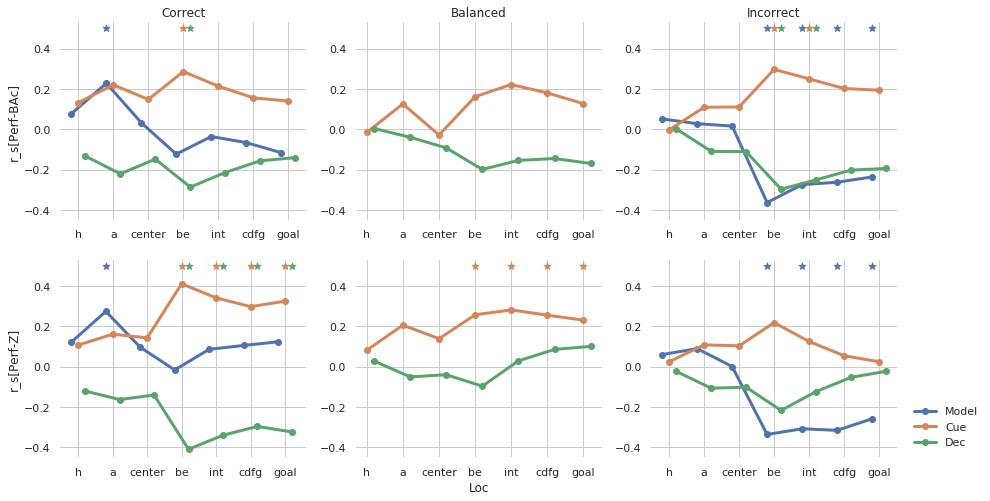

In [421]:
pal =sns.color_palette(desat=.9)[:3]
f,ax = plt.subplots(2,3,figsize=(15,8))
lw =3
n = len(pCoST)
P = np.abs(np.arctanh(CS)*np.sqrt((n-3)/1.06))>2
x=np.arange(7)
locs = ['h','a','center','be','int','cdfg','goal']
ii = 0
for tt in ['BAc','Z']:
    jj = 0
        
    for model in ['Correct','Balanced','Incorrect']:
        if model!='Balanced':
            ax[ii,jj].plot(x-0.2,CS.loc[(model,'Model'),tt],color=pal[0],label = 'Model',linewidth=lw,marker = 'o')
            cnt=0
            for i in P.loc[(model,'Model'),tt]:
                if i:
                    ax[ii,jj].scatter(cnt-0.2,0.5,50,marker='*',color=pal[0])
                cnt+=1
        # Cue   
        ax[ii,jj].plot(x,CS.loc[(model,'Cue'),tt],color=pal[1],label = 'Cue',linewidth=lw,marker = 'o')
        cnt=0
        for i in P.loc[(model,'Cue'),tt]:
            if i:
                ax[ii,jj].scatter(cnt,0.5,50,marker='*',color=pal[1])
            cnt+=1
        
        # Dec
        ax[ii,jj].plot(x+0.2,CS.loc[(model,'Desc'),tt],color=pal[2],label = 'Dec',linewidth=lw,marker = 'o')
        cnt=0
        for i in P.loc[(model,'Desc'),tt]:
            if i:
                ax[ii,jj].scatter(cnt+0.2,0.5,50,marker='*',color=pal[2])
            cnt+=1
            
        ax[ii,jj].set_ylim([-0.45,0.53])
        if ii==0:
            ax[ii,jj].set_title(model)
        jj+=1
        
        ax[ii,0].set_ylabel('r_s[Perf-{}]'.format(tt))
    ii+=1
for ii in np.arange(2):
    for jj in np.arange(3):
        ax[ii,jj].set_xticks(x)
        ax[ii,jj].set_xticklabels(locs)
ax[1,1].set_xlabel('Loc')
ax[1,2].legend(labels = ['Model','Cue','Dec'],loc=3,bbox_to_anchor=[1.03,0],frameon=False)

### stats on correct model

In [132]:
f = lambda x: np.log( (x+tol) /(1- (x+tol)))

subset = (All_PopSumDecRes['Decoder']=='Correct') &(All_PopSumDecRes['Test']=='Cue')  & (All_PopSumDecRes['nTrials']>=80) & (All_PopSumDecRes['nSeUnits']>=5)
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = All_PopSumDecRes[subset].copy()#All_PopSumDecRes[subset]

dat['L_BAc'] = f(dat['BAc']/100)
dat['L_pCoST'] =  f(dat['pCoST'])
dat.loc[dat['Z']>10,'Z'] =10
dat.loc[dat['Z']<-10,'Z'] = -10

dat = dat[~dat['L_BAc'].isnull()]
dat = dat[~dat['L_pCoST'].isnull()]

#md =smf.mixedlm('L_pCoST ~ Loc:L_BAc+L_BAc+nTrials+nSeUnits',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
md =smf.mixedlm('L_pCoST ~ Loc:L_BAc+L_BAc',data=dat,groups=dat['an'])

mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())

print('\n\n')
dat = dat[~dat['Z'].isnull()]
md =smf.mixedlm('L_pCoST ~ Loc:Z+Z',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())



            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   L_pCoST  
No. Observations:    315       Method:               REML     
No. Groups:          3         Scale:                0.2705   
Min. group size:     56        Likelihood:           -260.6952
Max. group size:     161       Converged:            Yes      
Mean group size:     105.0                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            2.228    0.434  5.129 0.000  1.376  3.079
L_BAc                0.181    0.128  1.414 0.157 -0.070  0.433
Loc[T.be]:L_BAc     -0.182    0.131 -1.386 0.166 -0.440  0.075
Loc[T.cdfg]:L_BAc   -0.180    0.131 -1.375 0.169 -0.436  0.076
Loc[T.center]:L_BAc -0.169    0.144 -1.174 0.240 -0.451  0.113
Loc[T.goal]:L_BAc   -0.183    0.131 -1.403 0.161 -0.440  0.073
Loc[T

### stats on balanced model

In [135]:

subset = (All_PopSumDecRes['Decoder']=='Balanced')  & (All_PopSumDecRes['nTrials']>=80) & (All_PopSumDecRes['nSeUnits']>=5)
#subset = (All_UniRes['Cond']=='Cue') | (All_UniRes['Cond']=='Desc') | (All_UniRes['Seg']=='A')
dat =[]
dat = All_PopSumDecRes[subset].copy()#All_PopSumDecRes[subset]

dat['L_BAc'] = f(dat['BAc']/100)
dat['L_pCoST'] =  f(dat['pCo'])
dat.loc[dat['Z']>10,'Z'] =10
dat.loc[dat['Z']<-10,'Z'] = -10

dat = dat[~dat['L_BAc'].isnull()]
dat = dat[~dat['L_pCoST'].isnull()]

#md =smf.mixedlm('L_pCoST ~ Loc:L_BAc+L_BAc*Test+nTrials+nSeUnits',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
md =smf.mixedlm('L_pCoST ~ 0+Loc:L_BAc+L_BAc*Test',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())

print('\n\n')
dat = dat[~dat['Z'].isnull()]
md =smf.mixedlm('L_pCoST ~ 0+Loc:Z+Z*Test',data=dat,groups=dat['an'])
#md =smf.mixedlm('L_pCo ~ aT * Cond',data=dat,groups=dat['an'])
mdf['x'] = md.fit()
print(mdf['x'].summary())
print(mdf['x'].wald_test_terms())

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   L_pCoST  
No. Observations:    611       Method:               REML     
No. Groups:          3         Scale:                0.0922   
Min. group size:     112       Likelihood:           -163.2832
Max. group size:     304       Converged:            Yes      
Mean group size:     203.7                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Test[Cue]            1.668    0.180  9.241 0.000  1.314  2.022
Test[Desc]           1.686    0.180  9.346 0.000  1.333  2.040
L_BAc                0.010    0.162  0.063 0.950 -0.307  0.327
Loc[T.be]:L_BAc      0.009    0.159  0.056 0.955 -0.302  0.320
Loc[T.cdfg]:L_BAc    0.016    0.159  0.103 0.918 -0.295  0.327
Loc[T.center]:L_BAc  0.017    0.178  0.095 0.924 -0.331  0.365
Loc[T